In [1]:
%%capture
import orca
import warnings; warnings.filterwarnings("ignore")

from lcog import datasources
from lcog import variables
from lcog import models

orca.run(['build_networks'])

%matplotlib inline

In [2]:
from urbansim.models import util
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep

mm.initialize()

Registering model step 'elcm1'
Registering model step 'elcm10'
Registering model step 'elcm11'
Registering model step 'elcm12'
Registering model step 'elcm13'
Registering model step 'elcm14'
Registering model step 'elcm15'
Registering model step 'elcm2'
Registering model step 'elcm3'
Registering model step 'elcm4'
Registering model step 'elcm5'
Registering model step 'elcm6'
Registering model step 'elcm7'
Registering model step 'elcm8'
Registering model step 'elcm9'
Registering model step 'hlcm1'
Registering model step 'hlcm2'
Registering model step 'household_relocation_choice_model'
Registering model step 'repm_duplex_townhome'
Registering model step 'repm_industrial'
Registering model step 'repm_multifamily'
Registering model step 'repm_office'
Registering model step 'repm_retail'
Registering model step 'repm_sf_detached'
Registering model step 'tenure_choice_model'
Registering model step 'tenure_choice_model1'
Registering model step 'tenure_choice_model2'
Registering model step 'te

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

from bokeh.io import output_notebook, show
from bokeh.plotting import Figure
from datashader.bokeh_ext import create_ramp_legend, create_categorical_legend

output_notebook()

import datashader.transfer_functions as tf

import datashader as ds
from datashader.colors import viridis

import seaborn as sb

from urbansim.models.util import (apply_filter_query, columns_in_filters, 
        columns_in_formula)
from choicemodels.tools import MergedChoiceTable
import numpy as np
from itertools import (product, combinations)
import random

def visualize_variable(variable_name):
    p = orca.get_table('buildings').to_frame(['x', 'y', variable_name])
    
    cvs = ds.Canvas(plot_width=1000, plot_height=700)
    agg = cvs.points(p, 'x', 'y', ds.mean(variable_name))
    img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
    return img

def corr_plot(selected_variables):
    cols = []
    for col in selected_variables:    
        if col.startswith('np'):
            cols.append(col.split('(')[-1][:-1])
        if ':' in col:
            cols.append(col.split(':')[-1])
        else:
            cols.append(col)

    X = orca.get_table('buildings').to_frame(cols)

    plt.subplots(figsize=(8, 8))
    sb.heatmap(X.corr(), annot=True, cmap="RdYlGn")
    plt.show()
    
def skew_plot(selected_variables):
    cols = []
    for col in selected_variables:    
        if col.startswith('np'):
            cols.append(col.split('(')[-1][:-1])
        if ':' in col:
            cols.append(col.split(':')[-1])
        else:
            cols.append(col)
            
    X = orca.get_table('buildings').to_frame(cols)
    X.skew().plot(kind='bar')
    
def summed_probas(sum_variable, probas):
    p = orca.get_table('buildings').to_frame([sum_variable])
    p['proba'] = probas

    summed_puma = p.groupby(sum_variable).proba.sum()

    (summed_puma / summed_puma.sum()).plot(kind='bar')


def plot_probas(proba):
    p = orca.get_table('buildings').to_frame(['x', 'y'])
    p['proba'] = proba
    
    cvs = ds.Canvas(plot_width=1000, plot_height=700)
    agg = cvs.points(p, 'x', 'y', ds.mean('proba'))
    img= tf.set_background(tf.shade(agg, cmap=viridis),"white")
    return img

import geopandas as gpd
def plot_probas_by_zonedistrict(proba, note= None):
    zones = gpd.read_file('data/zones/zones.geojson')
    zones_2 = zones.merge(orca.get_table('parcels').to_frame(['zone_id','zone_district_id']).groupby('zone_id').first(), on='zone_id', how='left')
    zone_districts = zones_2.dissolve(by= 'zone_district_id').reset_index()
    
    p = orca.get_table('buildings').to_frame(['zone_district_id'])
    p['proba'] = proba
    
    zone_districts = zone_districts.join(p.groupby('zone_district_id').sum()).fillna(0)
    # PLOT
    colors = 5
    cmap = 'YlOrRd'
    figsize = (12,8)
    title = 'Summed Probabilities by Zone District'
    ax = zone_districts.plot(column='proba', scheme='Quantiles', k=colors, legend=True, cmap = cmap, alpha=.8, 
                             figsize = figsize, 
                            linewidth=0.5, edgecolor='black')
    if note:
        ax.text(ax.xaxis.get_minpos(),ax.yaxis.get_minpos(),s='\n{}'.format(note))
    ax.set_title(title, fontdict={'fontsize': 15}, loc='left')
    ax.set_axis_off()
    return
#-------- probabilities Functions
def to_str(w):
    if isinstance(w, str):
        return w
    if isinstance(w, list):
        return ' & '.join(w) if len(w) > 1 else w[0]
    if not w:
        return " "

def create_probs_table(m, rep_chooser_filter = None, sample_alts= None, sample_choosers= None):
    filter_cols = columns_in_filters(to_str(m.chooser_filters) + " " + to_str(m.alt_filters) + to_str(rep_chooser_filter))
    colnames = columns_in_formula(m.model_expression) + columns_in_filters(filter_cols)

    alts = orca.get_table(m.alternatives).to_frame(colnames)
    alts = alts.query(to_str(m.alt_filters)) if m.alt_filters else alts

    obs = orca.get_table(m.choosers).to_frame(colnames)
    obs = obs.query(to_str(m.chooser_filters)) if m.chooser_filters else obs
    
    # Filter representative chooser based on rep_chooser_filter input
    if rep_chooser_filter:
        # check if rep_filter has columns from the interaction terms
        if (all(x in obs.columns for x in columns_in_filters(to_str(rep_chooser_filter)))):
            obs = obs.query(to_str(rep_chooser_filter))
        else:
            chooser_vars = [x for x in columns_in_formula(m.model_expression) if x in orca.get_table(m.choosers).columns]
            raise ValueError("Representative choosers' filters must be on these columns:\n *{}".format('\n *'.join(chooser_vars)))
    if sample_choosers:
        if sample_choosers <= len(obs):
            obs = obs.sample(n= sample_choosers)
        else:
            obs
    if len(obs) == 0:
        raise ValueError('No choosers left after filtering.')
    if len(alts) == 0:
        raise ValueError('No alternatives left after filtering.')
    
    if not sample_alts:
        sample_alts = len(alts)
    
    mtc = MergedChoiceTable(obs, alts, sample_size= sample_alts)
    probas = m.model.probabilities(mtc)
    probas = probas.reset_index(level=1).groupby('building_id').sum()
    return probas


def representative_choosers_filters(m):
    filter_cols = columns_in_filters(to_str(m.chooser_filters) + " " + to_str(m.alt_filters))
    colnames = columns_in_formula(m.model_expression) + columns_in_filters(filter_cols)
    obs = orca.get_table(m.choosers).to_frame(colnames)
    obs = obs.query(to_str(m.chooser_filters)) if m.chooser_filters else obs
    chooser_vars = [x for x in columns_in_formula(m.model_expression) if x in orca.get_table(m.choosers).columns]

    vars_conditions = {}
    top_n = 3
    for c in chooser_vars:
        n_uniques_include_most = 1.*obs[c].value_counts(normalize=True).head(top_n).sum() > 0.70
        if (obs[c].nunique() < 5) & (n_uniques_include_most):
            vars_conditions[c] = ['{} == {}'.format(c,x) for x in obs[c].unique()]
        elif (obs[c].nunique() < 10) & (n_uniques_include_most):
            # divide in quantiles
            q_1, q_2, q_3 = obs[c].quantile(.25), obs[c].quantile(.50), obs[c].quantile(.75)
            quartiles = [(obs[c].min(),q_1),(q_1,q_2),(q_2,q_3) ,(q_3,obs[c].max())]
            vars_conditions[c] = ['({0} > {1}) & ({0} < {2})'.format(c,x,y) for (x,y) in quartiles]
        elif not (n_uniques_include_most):
            # Assume is a continuous variable. Select rows that are in the middle.
            if obs[c].quantile(.40) == obs[c].quantile(.60):
                vars_conditions[c] = ['({0} == {1})'.format(c,obs[c].mean())]
            else:
                vars_conditions[c] = ['({0} > {1}) & ({0} < {2})'.format(c,obs[c].quantile(.40), obs[c].quantile(.60))]
        else:
            print('{} variable was not included in the set of combinations to characterize the representative chooser'.format(c))

    cond_combinations = [[v[0]] for (k,v) in vars_conditions.items() if len(v) == 2]
    cond_combinations.extend([v for (k,v) in vars_conditions.items() if len(v) == 3])
    
    # Create combinations bewteen 2 variables
    if len(vars_conditions) > 1:
        correlations = abs(obs[chooser_vars].corr().unstack())
        correlations.name = 'correl'
        correlations = correlations.reset_index()
        # Drop duplicated combinations
        correlations = correlations[~correlations[['level_0','level_1']].apply(frozenset, axis=1).duplicated()]
        # Drop combinations with correlation more than 0.60
        correlations = correlations[correlations.correl < 0.6]
        for i, k in correlations.iterrows():
            a = vars_conditions[k.level_0]
            b = vars_conditions[k.level_1]
            doubles_combinations = list(product(a,b))
            rand_idxs = random.sample(range(len(doubles_combinations)),2)
            cond_combinations.extend([doubles_combinations[x] for x in rand_idxs])
            
    # Create combinations bewteen all variables
    if len(vars_conditions) > 2:       
        big_combinations = list(product(*vars_conditions.values()))
        #select random combinations
        rand_idxs = random.sample(range(len(big_combinations)),3)
        cond_combinations.extend([big_combinations[x] for x in rand_idxs])
    
    final_comb = [' & '.join(x) if len(x) > 1 else x[0] for x in cond_combinations]

    #ask for combinations
    final_comb_text = ["{}- {}".format(x[0],x[1]) for x in enumerate(final_comb)]
    user_indexes = input("Choose the combination of households' variables to create segments to visualize probabilities:\n *{} \
          \n Please enter the combinations' numbers separated by commas (for example: 2,3,6)\n  ".format('\n *'.join(final_comb_text))).split(',')

    try:
        np.array(user_indexes).astype(int)
    except ValueError:
        print('\n ERROR: The entered values are numbers and/or are not separated by commas')
    else:
        user_indexes = np.array(user_indexes).astype(int)

    if not all([x in range(len(final_comb)) for x in user_indexes]):
        raise ValueError('The values entered are not in the list')
    
    return [final_comb[x] for x in user_indexes]

Loading BokehJS ...

## HLCM 1- Low Income Recent Movers

In [4]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['households']
m.chooser_filters = ['(recent_mover == 1) & (income_quartile == 1)']

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.alt_filters = 'residential_units > 0'
m.choice_column = 'building_id'

m.constrained_choices = True
m.alt_capacity = 'residential_units'

m.alt_sample_size = 30

In [74]:
selected_variables = ['ln_value_per_unit',
                     'is_multifamily',
                      'blocks_mean_residential_units',
                       'ln_locations_mean_non_residential_sqft',
                        'ln_zone_subdistricts_prop_sector_id_4',
                      'parcels_prop_tenure_1',
                      'zones_prop_income_quartile_1',
                     'hispanic_head:ln_zones_prop_hispanic_head_1',
                     'workers:ln_zones_total_jobs_5_am_peak_travel_time',
                     'no_workers:ln_zones_total_jobs_5_am_peak_travel_time']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:            784
Model:         Multinomial Logit   Df Residuals:                774
Method:       Maximum Likelihood   Df Model:                     10
Date:                 2019-02-05   Pseudo R-squ.:             0.510
Time:                      16:07   Pseudo R-bar-squ.:         0.507
AIC:                   2,631.208   Log-Likelihood:       -1,305.604
BIC:                   2,677.852   LL-Null:              -2,666.539
                                                          coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------------------------
ln_value_per_unit                                      -0.5277     0.027   -19.789     0.000             
is_multifamily                                          1.4446     0.108    13.351     0.000             
blocks_mean_residential_units   

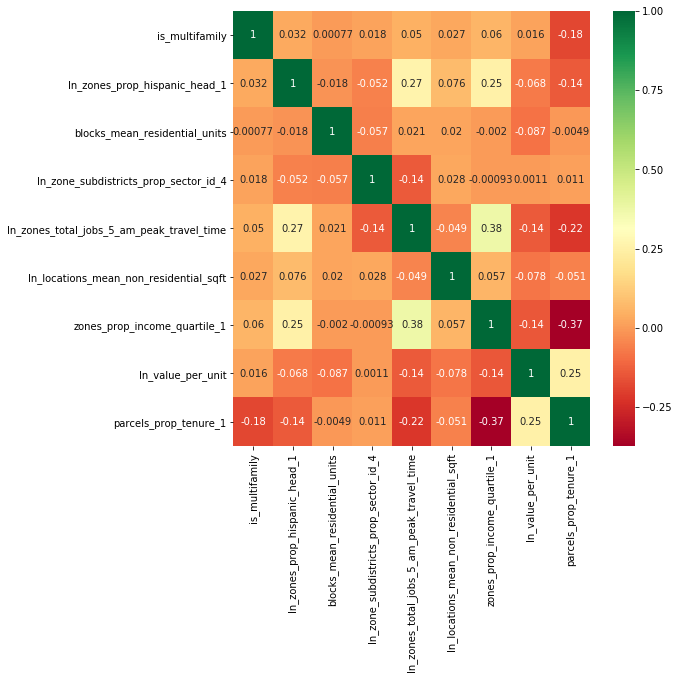

In [75]:
corr_plot(selected_variables)

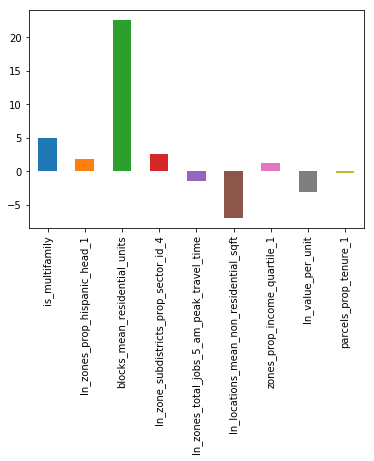

In [76]:
skew_plot(selected_variables)

#### Choose the combination of Households' Characteristics to plot buildings' probabilities

In [77]:
segments = representative_choosers_filters(m)
print(segments)

Choose the combination of households' variables to create segments to visualize probabilities:
 *0- hispanic_head == 0
 *1- no_workers == 1
 *2- hispanic_head == 1 & workers == 1
 *3- hispanic_head == 0 & workers == 1
 *4- hispanic_head == 0 & no_workers == 0
 *5- hispanic_head == 0 & no_workers == 1
 *6- hispanic_head == 0 & workers == 3 & no_workers == 1
 *7- hispanic_head == 0 & workers == 2 & no_workers == 0
 *8- hispanic_head == 1 & workers == 0 & no_workers == 0           
 Please enter the combinations' numbers separated by commas (for example: 2,3,6)
  0
['hispanic_head == 0']


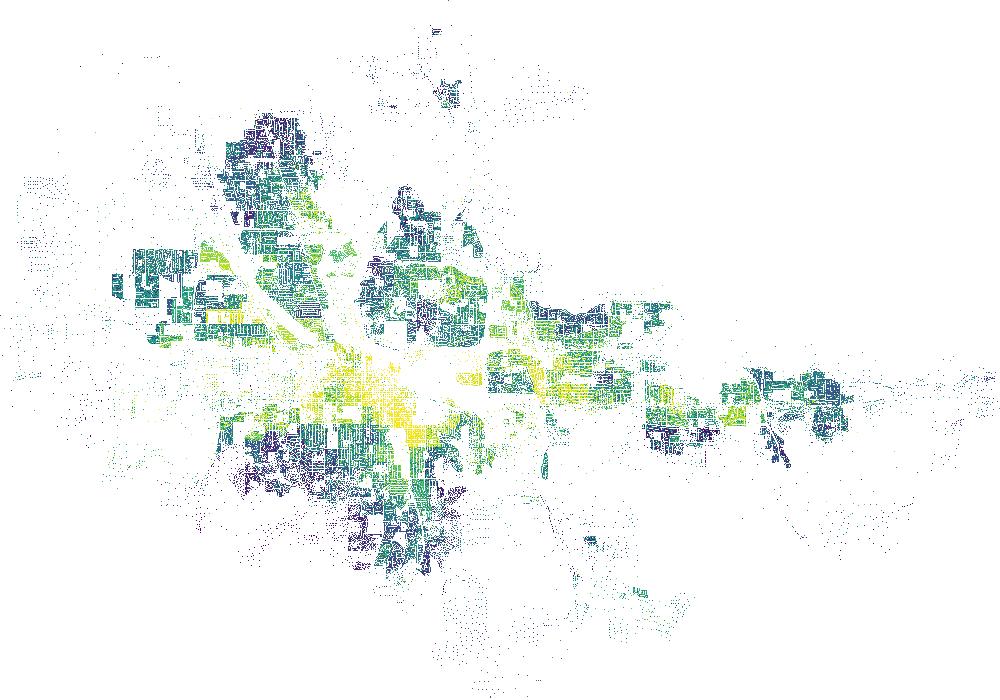

In [78]:
probas = create_probs_table(m, rep_chooser_filter=segments[0], sample_choosers= 1)
plot_probas(probas)

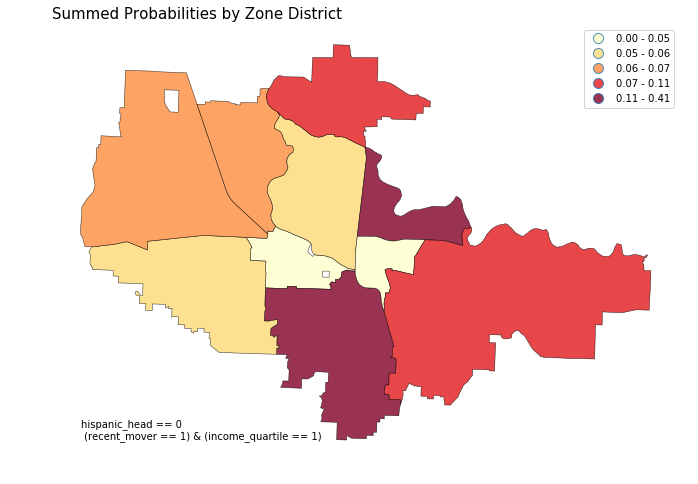

In [80]:
footnote = '{} \n {}'.format(segments[0], m.chooser_filters[0])
plot_probas_by_zonedistrict(probas, footnote)

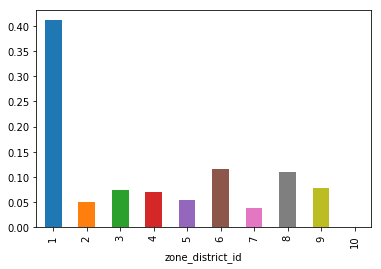

In [81]:
summed_probas('zone_district_id', probas)

In [82]:
m.name = 'hlcm1'
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'income_quartile == 1']

mm.register(m)

Saving 'hlcm1.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'hlcm1'


## HLCM 2- Mid Income Recent Movers

In [83]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['households']
m.chooser_filters = ['(recent_mover == 1) & (income_quartile > 1)']

# Define the geographic alternatives agent is selecting amongst

m.alternatives = ['buildings']
m.alt_filters = 'residential_units > 0'
m.choice_column = 'building_id'

m.constrained_choices = True
m.alt_capacity = 'residential_units'

m.alt_sample_size = 30

In [84]:
selected_variables = ['ln_value_per_unit',
                      'ln_year_built',
                      'persons:ln_residential_sqft',
                     'zero_carowner:ln_zones_total_jobs_5_am_peak_travel_time',
                      'carowner:ln_zones_total_jobs_5_am_peak_travel_time',
                      'has_children:ln_blocks_prop_building_type_id_1110',
                      'no_children:ln_blocks_prop_building_type_id_1110',
                      'ln_parcels_ratio_households_to_residential_units',
                     ]

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:            741
Model:         Multinomial Logit   Df Residuals:                733
Method:       Maximum Likelihood   Df Model:                      8
Date:                 2019-02-05   Pseudo R-squ.:             0.263
Time:                      16:09   Pseudo R-bar-squ.:         0.260
AIC:                   3,730.139   Log-Likelihood:       -1,857.069
BIC:                   3,767.003   LL-Null:              -2,520.287
                                                             coef   std err         z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------------------------------
ln_value_per_unit                                         -0.6408     0.023   -28.112     0.000             
ln_year_built                                             13.1676     0.091   144.338     0.000             
persons:ln_residenti

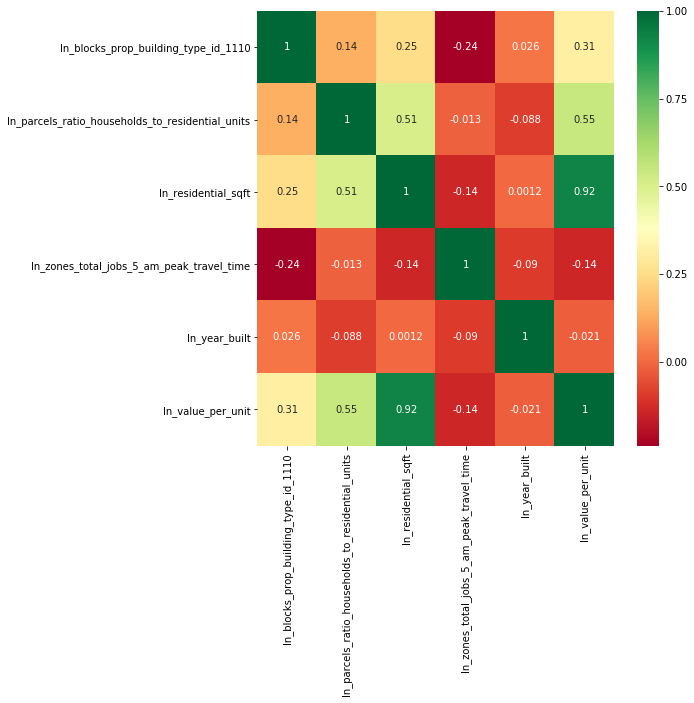

In [85]:
corr_plot(selected_variables)

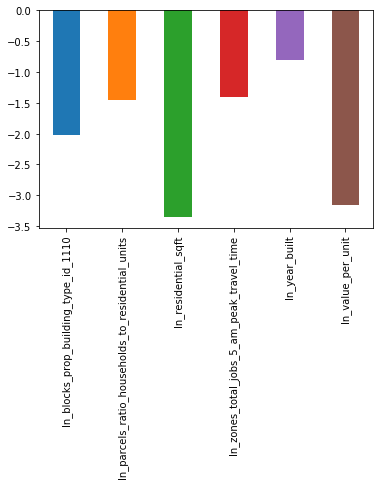

In [86]:
skew_plot(selected_variables)

#### Choose the combination of Households' Characteristics to plot buildings' probabilities

In [87]:
segments = representative_choosers_filters(m)
print(segments)

Choose the combination of households' variables to create segments to visualize probabilities:
 *0- zero_carowner == 0
 *1- carowner == 1
 *2- has_children == 1
 *3- no_children == 0
 *4- (persons > 3.0) & (persons < 11) & zero_carowner == 0
 *5- (persons > 1.0) & (persons < 2.0) & zero_carowner == 0
 *6- (persons > 1.0) & (persons < 2.0) & carowner == 0
 *7- (persons > 2.0) & (persons < 3.0) & carowner == 0
 *8- zero_carowner == 1 & has_children == 1
 *9- zero_carowner == 0 & has_children == 0
 *10- zero_carowner == 0 & no_children == 1
 *11- zero_carowner == 1 & no_children == 1
 *12- carowner == 0 & has_children == 1
 *13- carowner == 1 & has_children == 0
 *14- carowner == 0 & no_children == 1
 *15- carowner == 1 & no_children == 1
 *16- (persons > 1) & (persons < 1.0) & zero_carowner == 1 & carowner == 1 & has_children == 0 & no_children == 1
 *17- (persons > 1.0) & (persons < 2.0) & zero_carowner == 1 & carowner == 1 & has_children == 1 & no_children == 0
 *18- (persons > 1) & (p

#### Plot the probabilities of the household's segment you selected in any of the above combinations. Set the index to the segments list

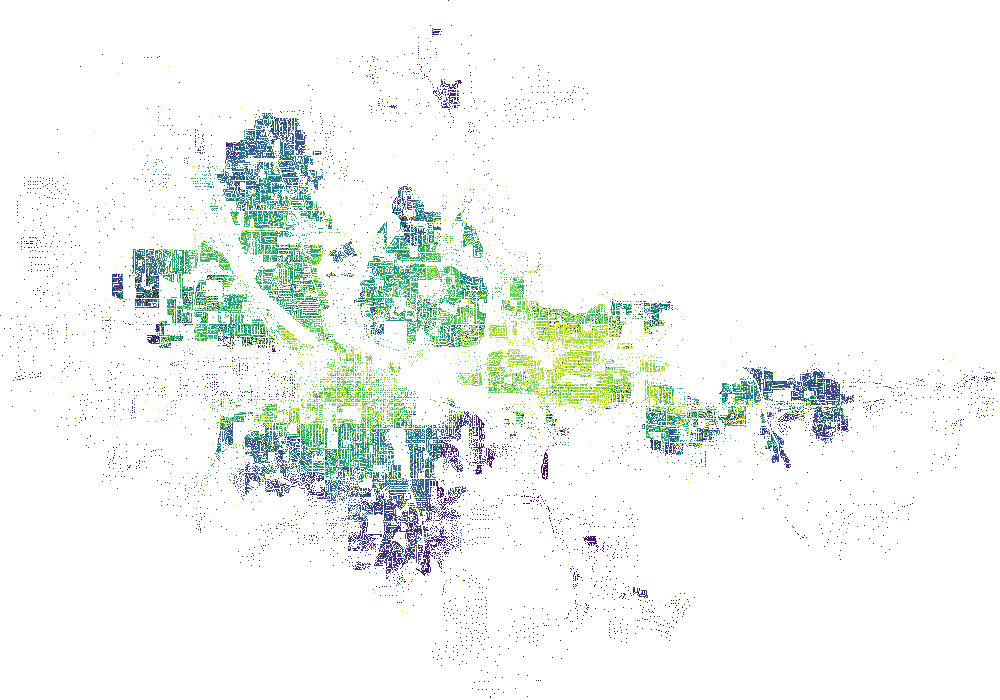

In [88]:
probas = create_probs_table(m, rep_chooser_filter=segments[0], sample_choosers= 1)
plot_probas(probas)

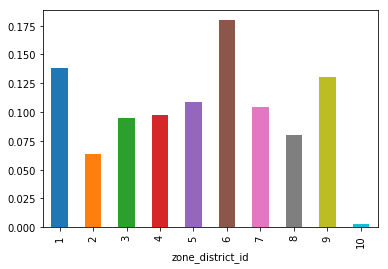

In [89]:
summed_probas('zone_district_id', probas)

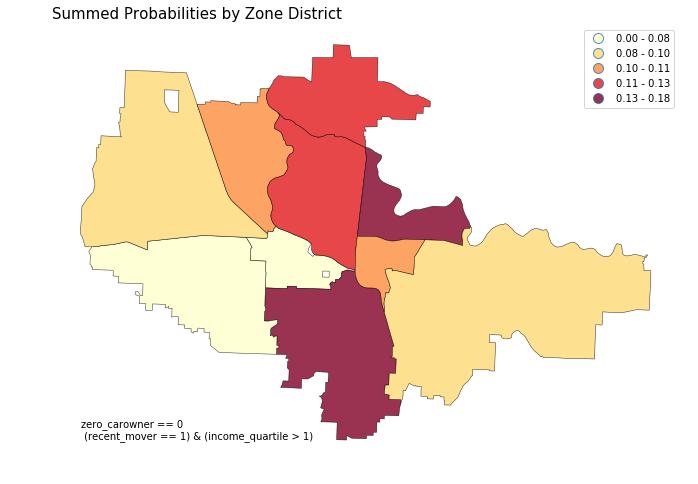

In [90]:
footnote = '{} \n {}'.format(segments[0], m.chooser_filters[0])
plot_probas_by_zonedistrict(probas, footnote)

In [91]:
m.name = 'hlcm2'
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'income_quartile > 1']

mm.register(m)

Saving 'hlcm2.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'hlcm2'


## ELCM1: Agriculture, Mining & Forestry

In [4]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 1']

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
# m.alt_filters = 'non_residential_sqft > 0'
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [5]:
selected_variables = ['ln_non_residential_sqft',
                     'ln_acres',
                    'ln_blocks_prop_repm_id_res_sf_detached',
                      'ln_blocks_prop_repm_id_duplex_townhome',
                     'ln_blocks_density_buildings',
                     'parcels_total_households']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating acres to buildings from parcels
Disaggregating total_households to buildings from parcels
Calculating number of households for parcels
Disaggregating prop_repm_id_duplex_townhome to buildings from blocks
Disaggregating block_id to buildings from parcels
Calculating proportion repm_id duplex_townhome for blocks
Calculating number of buildings for blocks
Disaggregating prop_repm_id_res_sf_detached to buildings from blocks
Calculating proportion repm_id res_sf_detached for blocks
Disaggregating density_buildings to buildings from blocks
Calculating density of buildings for blocks
Calculating sum_acres of parcels for blocks


        0.00090787]), array([[1834.11114673]]), {'grad': array([ 1.34366680e-05, -2.02331580e-06,  1.91059913e-07, -5.82949294e-08,
       -1.51926505e-07,  2.37829638e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 115, 'nit': 60, 'warnflag': 2})


                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:            746
Model:         Multinomial Logit   Df Residuals:                740
Method:       Maximum Likelihood   Df Model:                      6
Date:                 2019-02-05   Pseudo R-squ.:             0.277
Time:                      16:22   Pseudo R-bar-squ.:         0.275
AIC:                   3,680.222   Log-Likelihood:       -1,834.111
BIC:                   3,707.911   LL-Null:              -2,537.293
                                            coef   std err         z     P>|z|   Conf. Int.
-------------------------------------------------------------------------------------------
ln_non_residential_sqft                   0.2753     0.009    31.812     0.000             
ln_acres                                  0.6194     0.051    12.264     0.000             
ln_blocks_prop_repm_id_res_sf_detached   -0.7664     0.223    -3.441     0.001          

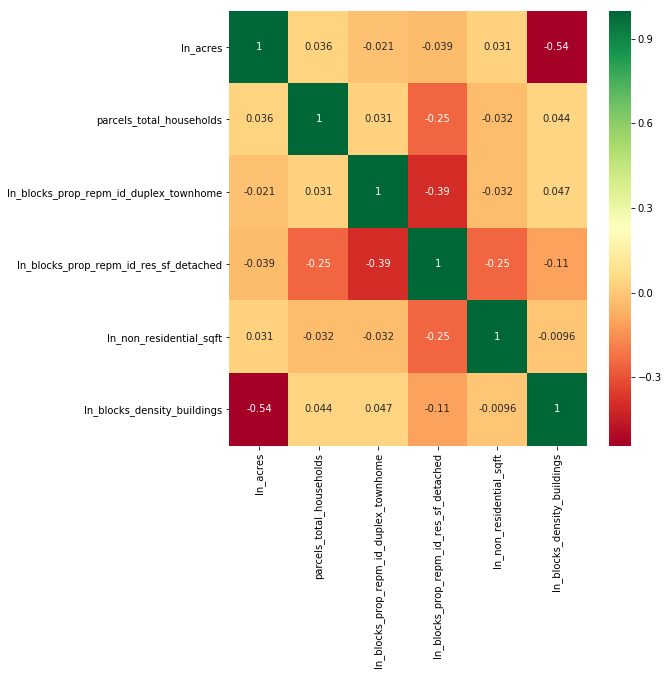

In [6]:
corr_plot(selected_variables)

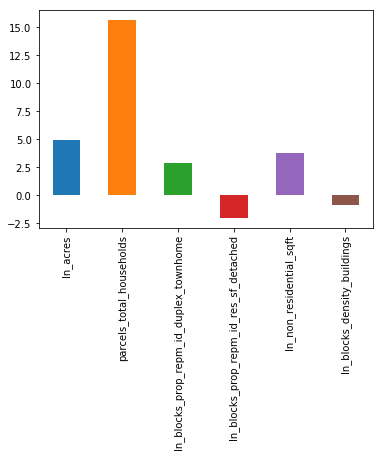

In [7]:
skew_plot(selected_variables)

Disaggregating zone_district_id to buildings from parcels


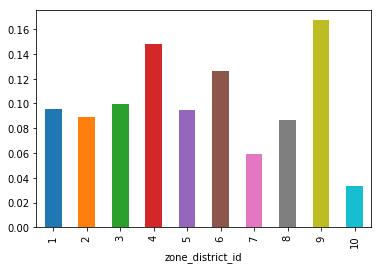

In [8]:
probas = create_probs_table(m)
summed_probas('zone_district_id', probas)

C:\Users\Juan\Anaconda3\envs\lcog\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


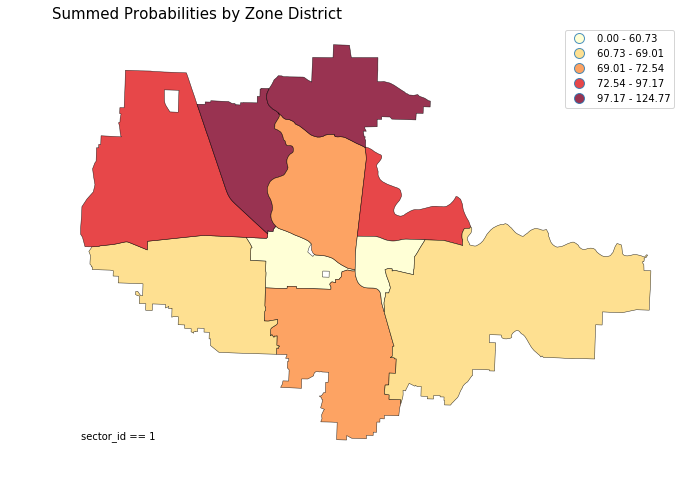

In [9]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

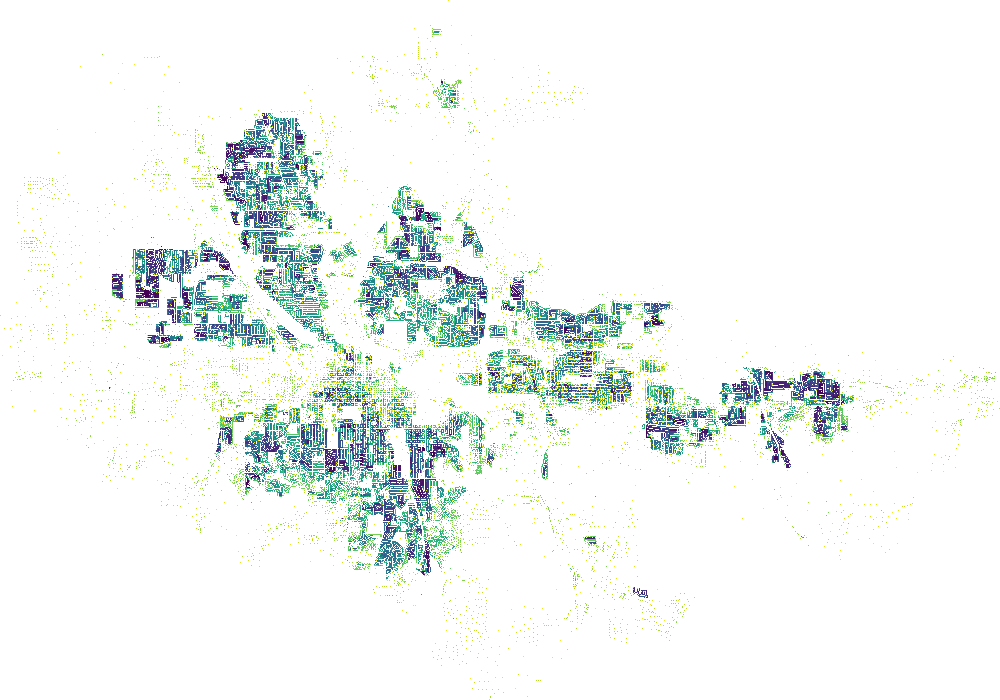

In [12]:
plot_probas(probas)

In [13]:
m.name = 'elcm1'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 1']
mm.register(m)

Saving 'elcm1.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm1'


## ELCM2 : Arts, Entertainment, and Recreation

In [14]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 2']

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
# m.alt_filters = 'non_residential_sqft > 0'
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [21]:
selected_variables = ['ln_block_groups_prop_sector_id_2',
                     'ln_blocks_prop_building_type_id_4290',
                     'zones_sum_persons_5_md_offpeak_travel_time',
                     'ln_blocks_density_households',
                     'zones_total_jobs_5_md_offpeak_travel_time',
                     'ln_parcels_density_jobs',
                     'ln_non_residential_sqft',
                     'ln_parcels_prop_building_type_id_1220',
                     'parcels_mean_income_ave_2000_flat',
                     'blocks_mean_year_built']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_building_type_id_4290 to buildings from blocks
Calculating proportion building_type_id 4290.0 for blocks
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          1,340
Model:         Multinomial Logit   Df Residuals:              1,330
Method:       Maximum Likelihood   Df Model:                     10
Date:                 2019-02-05   Pseudo R-squ.:             0.874
Time:                      16:27   Pseudo R-bar-squ.:         0.872
AIC:                   1,171.112   Log-Likelihood:         -575.556
BIC:                   1,223.117   LL-Null:              -4,557.604
                                                coef   std err         z     P>|z|   Conf. Int.
-----------------------------------------------------------------------------------------------
ln_block_groups_prop_sector_id_2             29.7635     1.669    17.831     0.000             
ln_blocks_prop_building_type_id_4290       

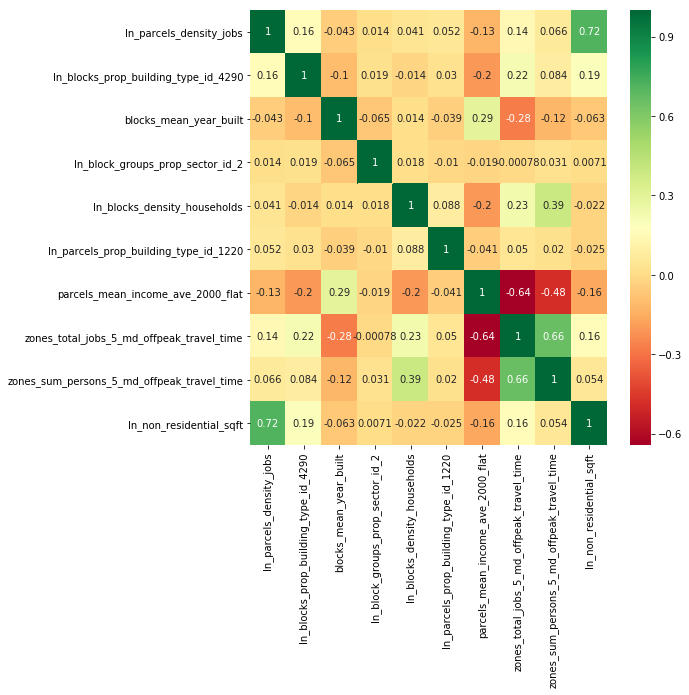

In [22]:
corr_plot(selected_variables)

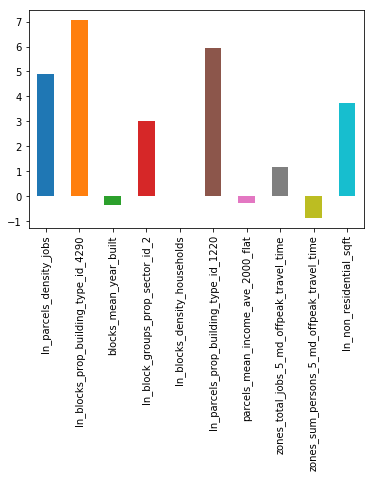

In [23]:
skew_plot(selected_variables)

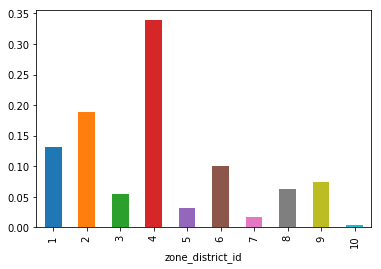

In [28]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

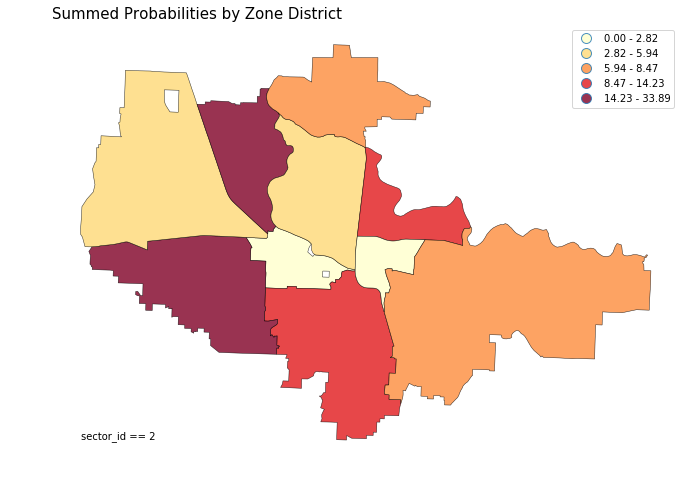

In [29]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

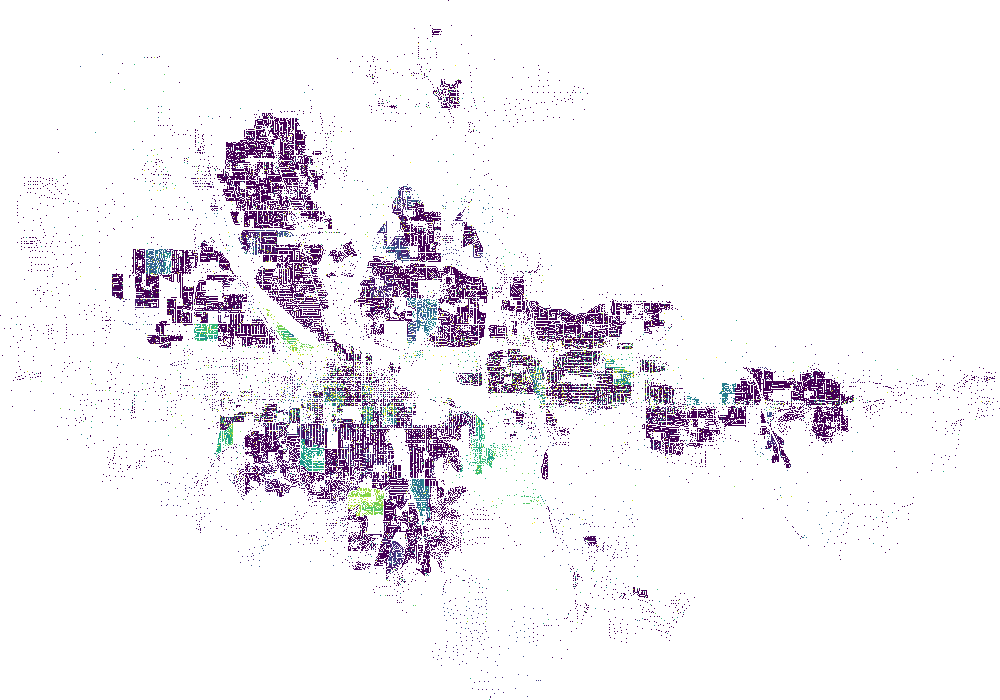

In [30]:
plot_probas(probas)

In [31]:
m.name = 'elcm2'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 2']
mm.register(m)

Saving 'elcm2.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm2'


## ELCM3 : Construction

In [32]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 3']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [33]:
selected_variables = ['block_groups_prop_building_type_id_1220',
                     'zones_total_jobs_15_md_offpeak_travel_time',
                     'ln_blocks_mean_acres',
                     'parcels_mean_income_ave_3600_linear',
                     'block_groups_density_buildings',
                     'ln_non_residential_sqft',
                     'ln_parcels_prop_building_type_id_5100',
                     'zones_total_jobs',
                     'blocks_prop_sector_id_3']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating mean_income_ave_3600_linear to buildings from parcels
Disaggregating prop_sector_id_3 to buildings from blocks
Disaggregating block_id to jobs from parcels
Calculating proportion sector_id 3 for blocks
Calculating number of jobs for blocks
Disaggregating mean_acres to buildings from blocks
Calculating mean_acres of parcels for blocks
Disaggregating total_jobs_15_md_offpeak_travel_time to buildings from zones
Disaggregating density_buildings to buildings from block_groups
Calculating density of buildings for block_groups
Calculating number of buildings for block_groups
Calculating sum_acres of parcels for block_groups
Disaggregating prop_building_type_id_5100 to buildings from parcels
Calculating proportion building_type_id 5100.0 for parcels
Disaggregating total_jobs to buildings from zones
Disaggregating prop_building_type_id_1220 to buildings from block_groups
Calculating proportion building_type_id 1220.0 for block_groups


       -2.30618593e-01,  3.72233720e-01,  1.63336648e+00,  3.21159925e-04,
        4.26467635e+00]), array([[2292.70097045]]), {'grad': array([-0.02719383, -0.34505073, -0.01193085,  0.00539866, -0.00188835,
       -0.00649298, -0.00342422, -0.13707394,  0.00856867]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 765, 'nit': 602, 'warnflag': 2})


                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,991
Method:       Maximum Likelihood   Df Model:                      9
Date:                 2019-02-05   Pseudo R-squ.:             0.663
Time:                      16:29   Pseudo R-bar-squ.:         0.662
AIC:                   4,603.402   Log-Likelihood:       -2,292.701
BIC:                   4,653.810   LL-Null:              -6,802.395
                                                coef   std err         z     P>|z|   Conf. Int.
-----------------------------------------------------------------------------------------------
block_groups_prop_building_type_id_1220      -0.0451     1.041    -0.043     0.965             
zones_total_jobs_15_md_offpeak_travel_time   -0.0000     0.000    -0.008     0.993             
ln_blocks_mean_acres                         -0.2983     0.064    -4.684

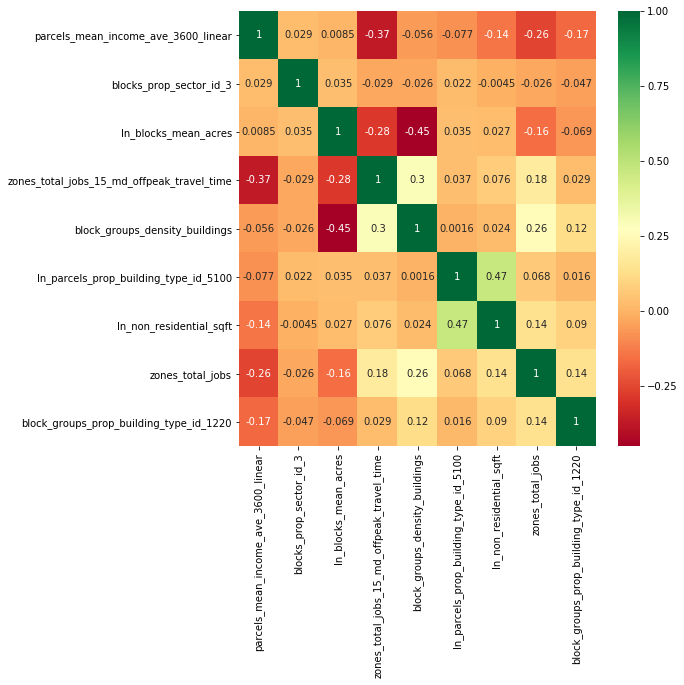

In [34]:
corr_plot(selected_variables)

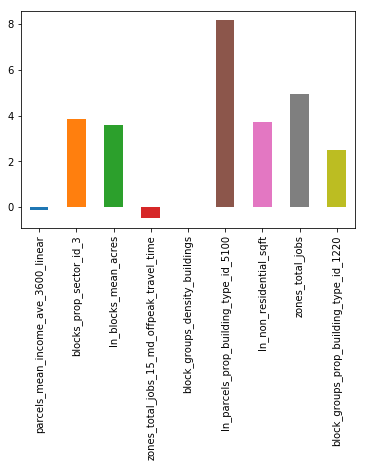

In [35]:
skew_plot(selected_variables)

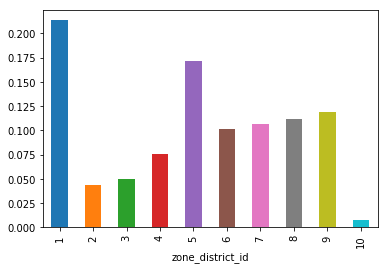

In [36]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

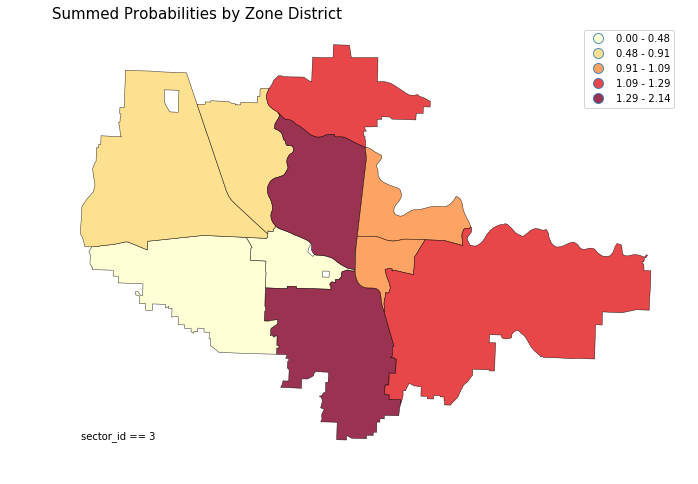

In [37]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

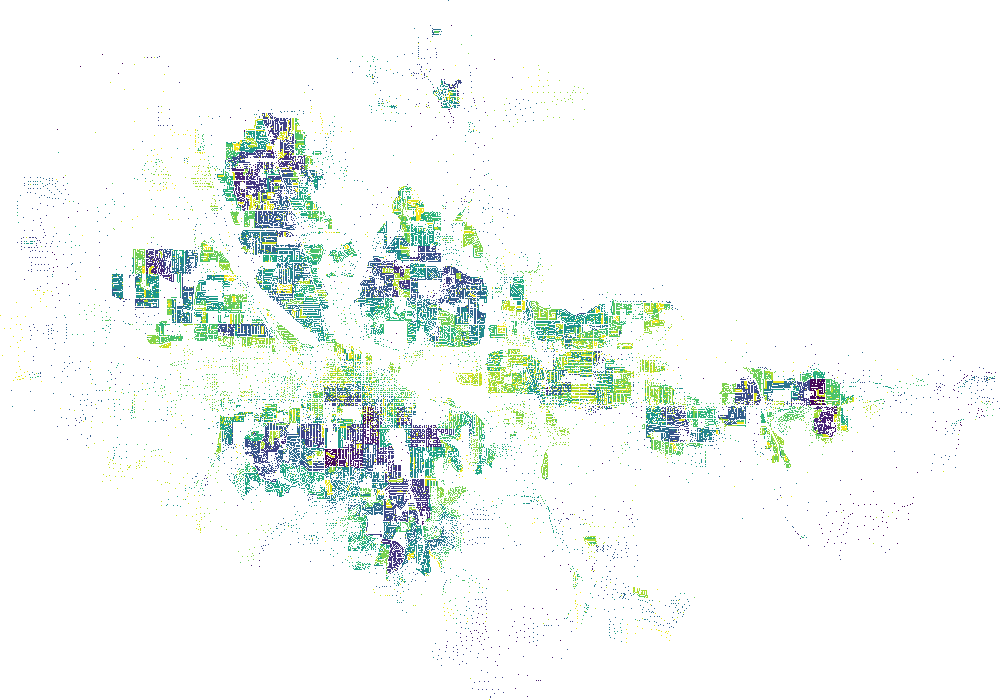

In [38]:
plot_probas(probas)

In [39]:
m.name = 'elcm3'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 3']
mm.register(m)

Saving 'elcm3.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm3'


## ELCM4 : Education

In [40]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 4']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [41]:
selected_variables = ['ln_non_residential_sqft',
                     'block_groups_mean_year_built',
                     'ln_acres',
                     'ln_blocks_prop_sector_id_4',
                     'ln_blocks_prop_building_type_id_5100',
                     'zones_total_jobs_5_md_offpeak_travel_time',
                     'ln_parcels_sum_children_ave_4400_flat']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_sector_id_4 to buildings from blocks
Calculating proportion sector_id 4 for blocks
Disaggregating sum_children_ave_4400_flat to buildings from parcels
Calculating sum_children of households for parcels
Disaggregating mean_year_built to buildings from block_groups
Calculating mean_year_built of buildings for block_groups
Disaggregating prop_building_type_id_5100 to buildings from blocks
Calculating proportion building_type_id 5100.0 for blocks
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,993
Method:       Maximum Likelihood   Df Model:                      7
Date:                 2019-02-05   Pseudo R-squ.:             0.967
Time:                      16:29   Pseudo R-bar-squ.:         0.966
AIC:                     465.550   Log-Likelihood:         -225.775
BIC:                     504.756   LL-Null:              

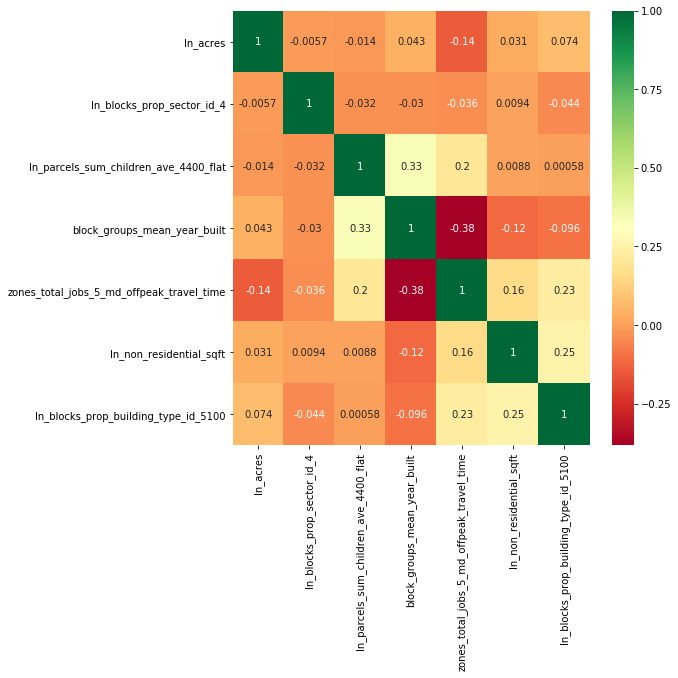

In [42]:
corr_plot(selected_variables)

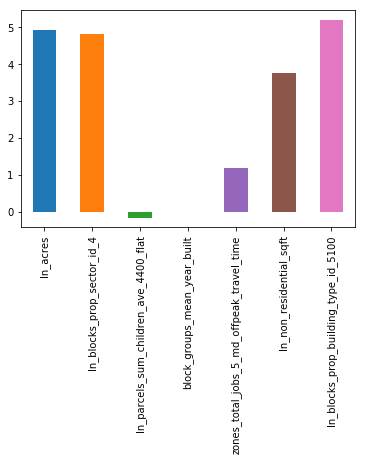

In [44]:
skew_plot(selected_variables)

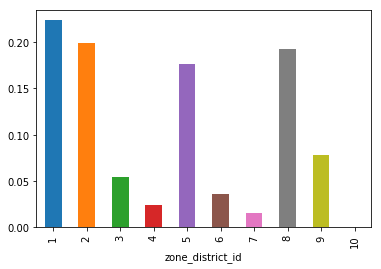

In [43]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

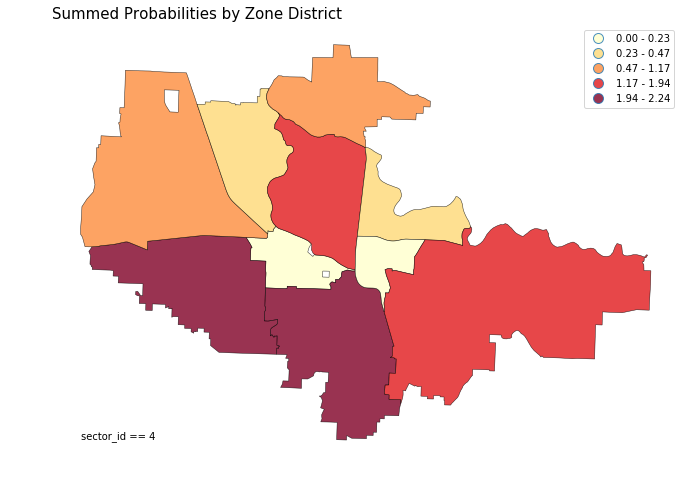

In [45]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

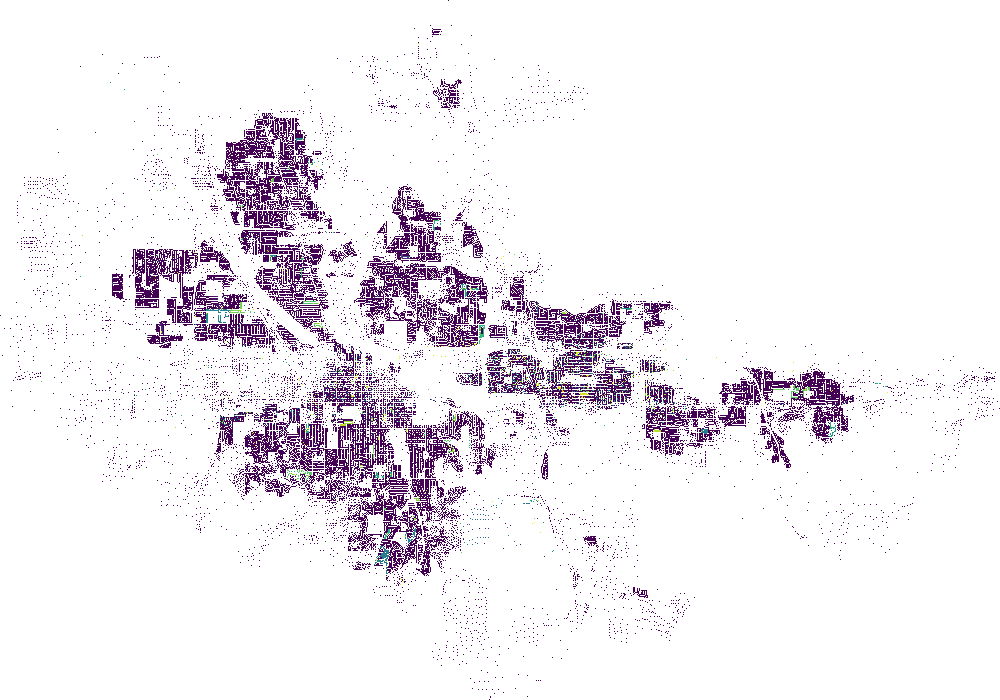

In [46]:
plot_probas(probas)

In [47]:
m.name = 'elcm4'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 4']
mm.register(m)

Saving 'elcm4.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm4'


## ELCM5 : Food Services and Drinking Places

In [48]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 5']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [49]:
selected_variables = ['ln_parcels_ratio_jobs_to_households',
                     'is_warehouse','blocks_mean_year_built',
                    'blocks_prop_sector_id_11',
                      'blocks_prop_sector_id_6',
                     'ln_parcels_mean_non_residential_sqft_ave_400_flat',  
                     ]

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating ratio_jobs_to_households to buildings from parcels
Calculating ratio of jobs to households for parcels
Disaggregating mean_non_residential_sqft_ave_400_flat to buildings from parcels
Calculating mean_non_residential_sqft of buildings for parcels
Disaggregating prop_sector_id_6 to buildings from blocks
Calculating proportion sector_id 6 for blocks
Disaggregating prop_sector_id_11 to buildings from blocks
Calculating proportion sector_id 11 for blocks
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,994
Method:       Maximum Likelihood   Df Model:                      6
Date:                 2019-02-05   Pseudo R-squ.:             0.786
Time:                      16:30   Pseudo R-bar-squ.:         0.785
AIC:                   2,927.471   Log-Likelihood:       -1,457.736
BIC:                   2,961.077   LL-Null:            

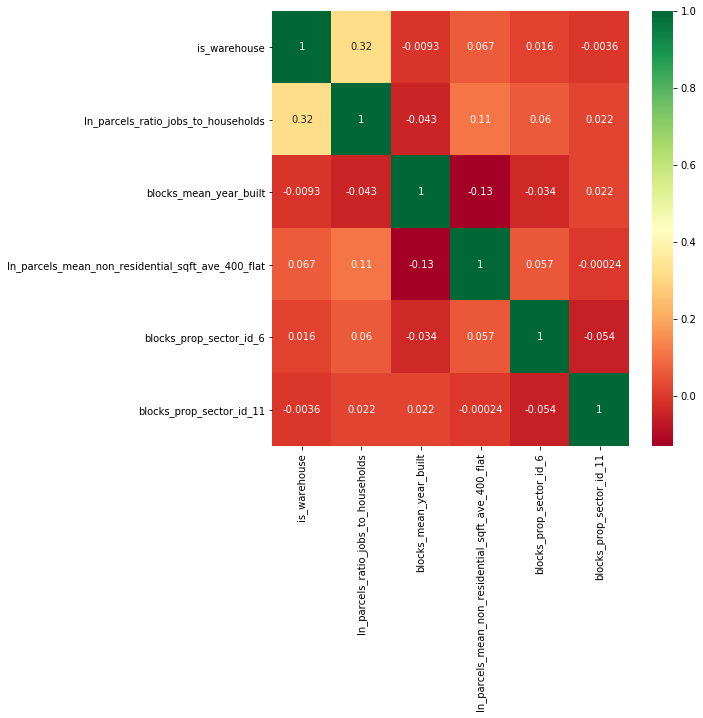

In [50]:
corr_plot(selected_variables)

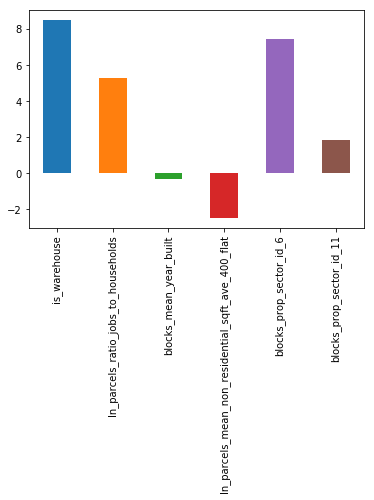

In [51]:
skew_plot(selected_variables)

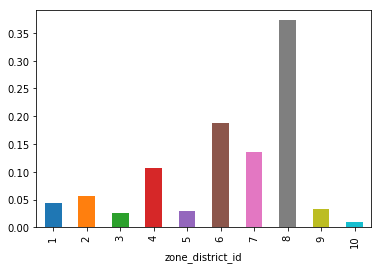

In [53]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

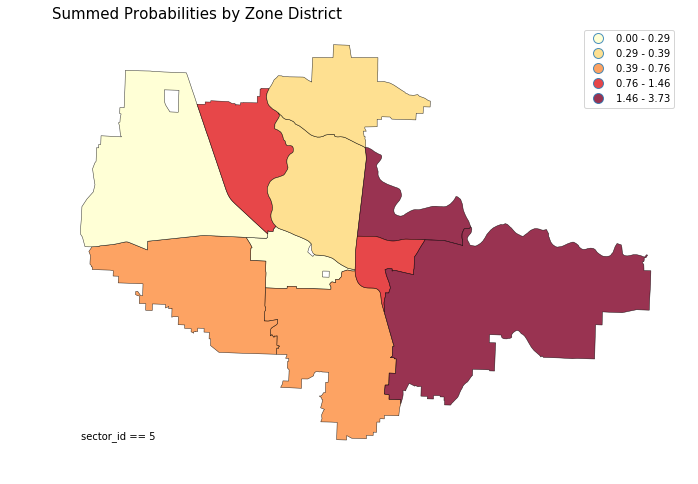

In [54]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

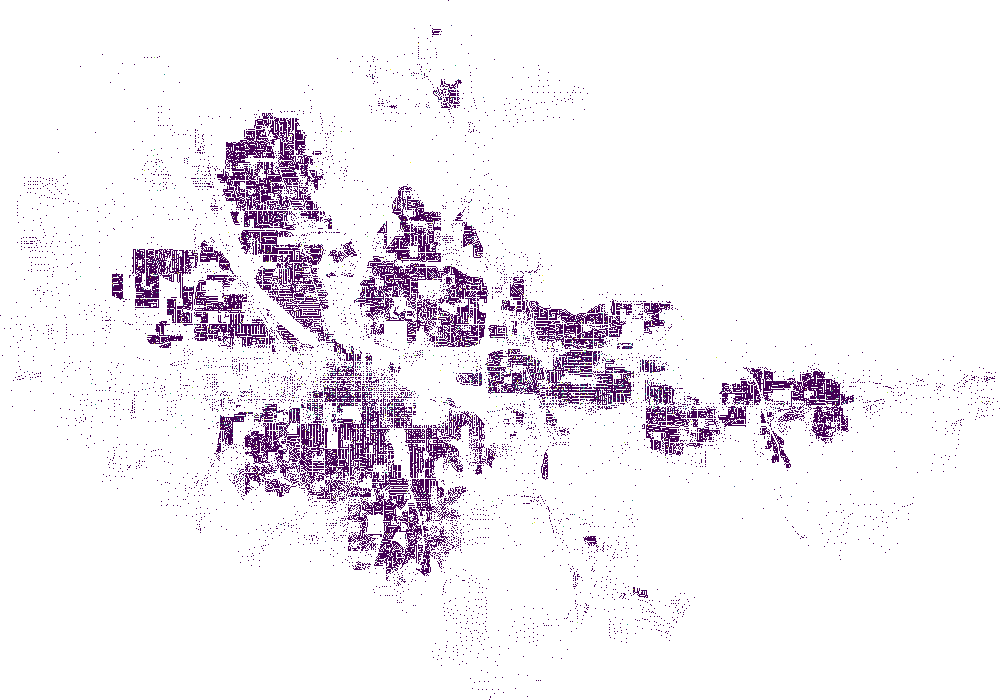

In [55]:
plot_probas(probas)

In [56]:
m.name = 'elcm5'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 5']
mm.register(m)

Saving 'elcm5.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm5'


## ELCM6 : Government

In [57]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 6']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [59]:
selected_variables = ['ln_zones_total_jobs',
                     'ln_acres',
                     'ln_non_residential_sqft',
                     'zones_total_jobs_15_am_peak_travel_time',
                     'ln_zones_prop_building_type_id_4290']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_building_type_id_4290 to buildings from zones
Calculating proportion building_type_id 4290.0 for zones
Calculating number of buildings for zones
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,995
Method:       Maximum Likelihood   Df Model:                      5
Date:                 2019-02-05   Pseudo R-squ.:             0.839
Time:                      16:31   Pseudo R-bar-squ.:         0.838
AIC:                   2,202.206   Log-Likelihood:       -1,096.103
BIC:                   2,230.211   LL-Null:              -6,802.395
                                              coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------------
ln_zones_total_jobs                         0.5487     0.039    13.992     0.000             
ln_acres 

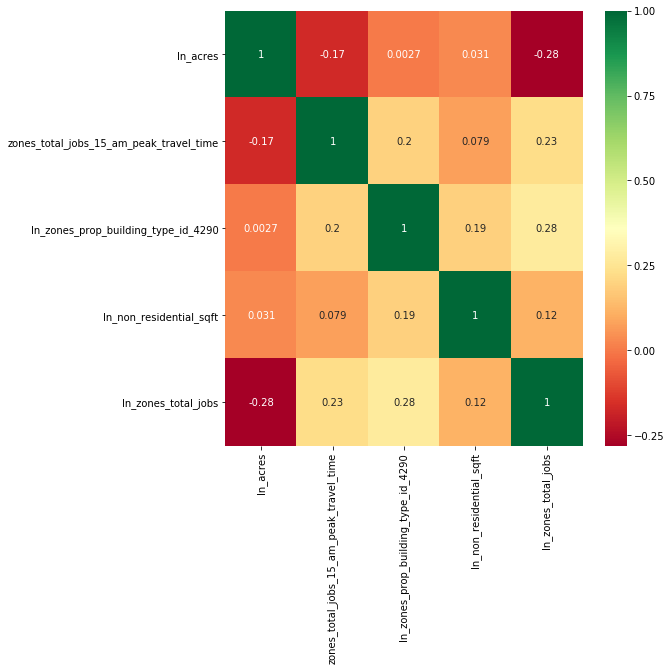

In [60]:
corr_plot(selected_variables)

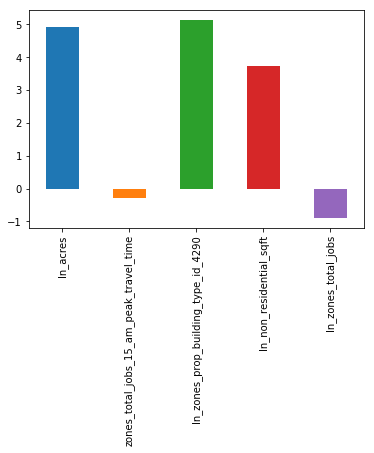

In [61]:
skew_plot(selected_variables)

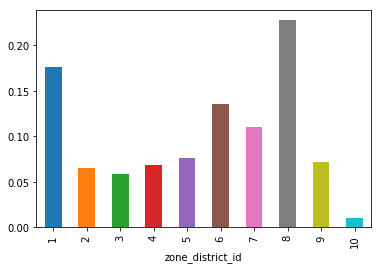

In [62]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

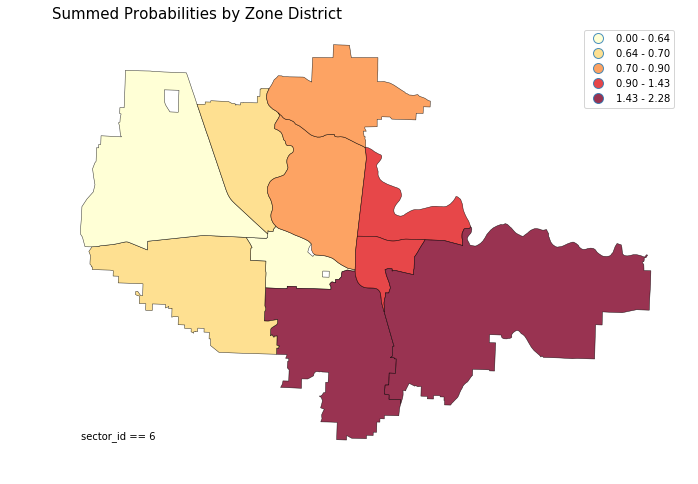

In [63]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

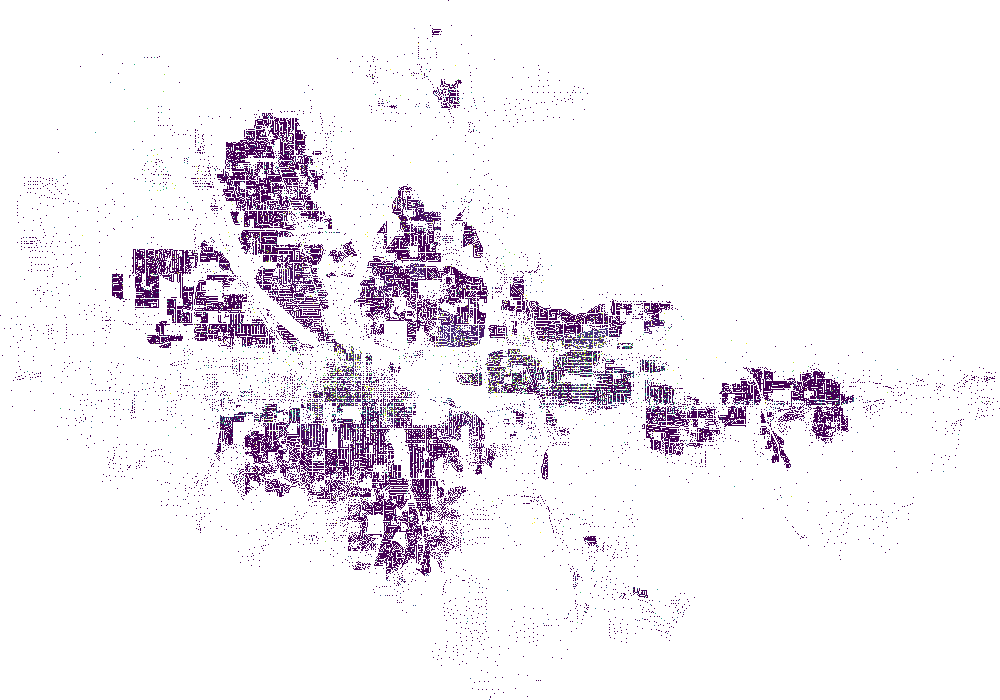

In [64]:
plot_probas(probas)

In [66]:
m.name = 'elcm6'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 6']
mm.register(m)

Saving 'elcm6.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm6'


## ELCM7: Health and Social Services

In [67]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 7']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [68]:
selected_variables = ['ln_parcels_prop_building_type_id_4100',
                     'parcels_mean_year_built',
                     'ln_blocks_prop_building_type_id_5100',
                     'ln_non_residential_sqft',
                     'zones_total_jobs_15_am_peak_travel_time',
                     'block_groups_density_buildings']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating mean_year_built to buildings from parcels
Calculating mean_year_built of buildings for parcels
Disaggregating prop_building_type_id_4100 to buildings from parcels
Calculating proportion building_type_id 4100.0 for parcels
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,994
Method:       Maximum Likelihood   Df Model:                      6
Date:                 2019-02-05   Pseudo R-squ.:             0.550
Time:                      16:32   Pseudo R-bar-squ.:         0.549
AIC:                   6,137.729   Log-Likelihood:       -3,062.864
BIC:                   6,171.334   LL-Null:              -6,802.395
                                             coef   std err         z     P>|z|   Conf. Int.
--------------------------------------------------------------------------------------------
ln_parcels_prop_building_type_id_

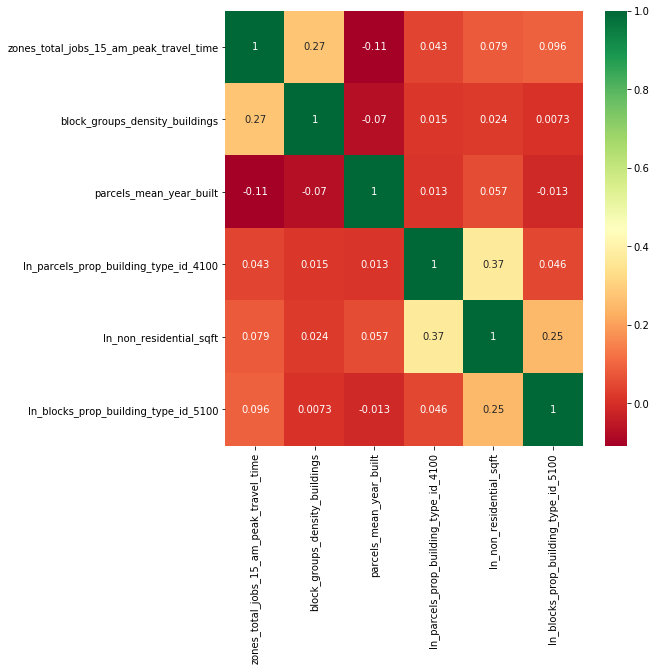

In [69]:
corr_plot(selected_variables)

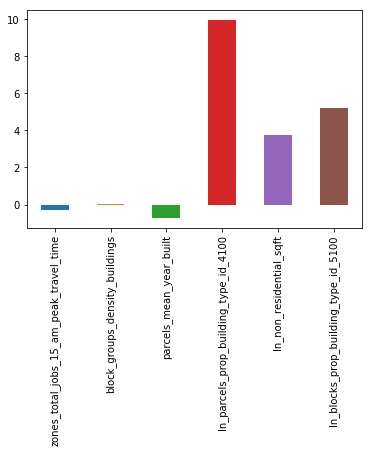

In [70]:
skew_plot(selected_variables)

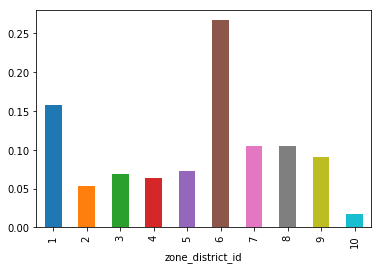

In [72]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

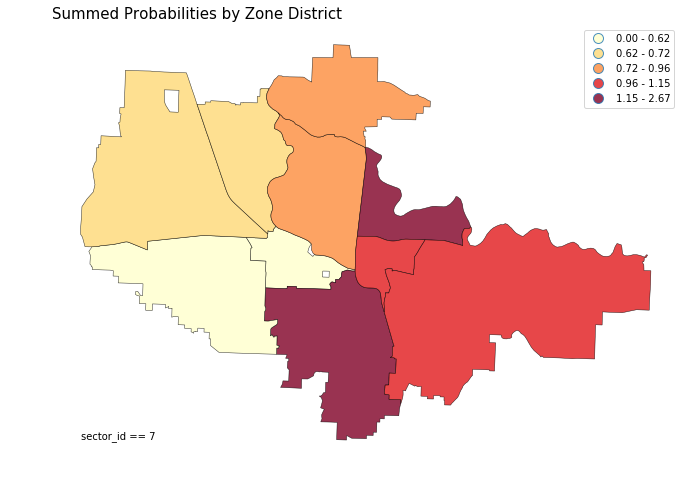

In [73]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

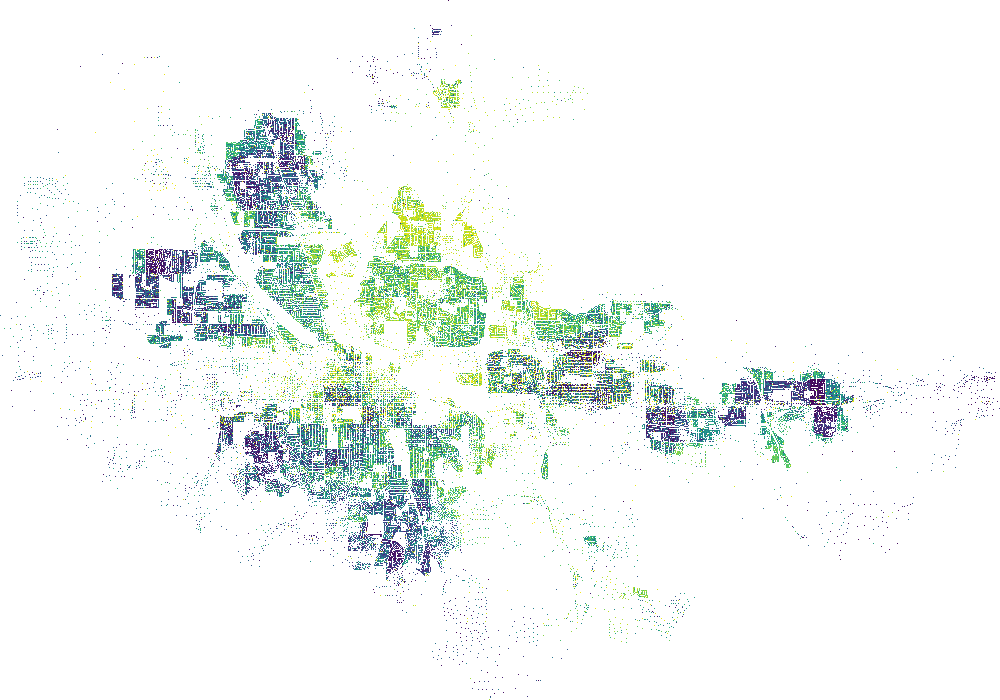

In [74]:
plot_probas(probas)

In [75]:
m.name = 'elcm7'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 7']
mm.register(m)

Saving 'elcm7.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm7'


## ELCM8: Manufacturing (except high tech)

In [76]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 8']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [77]:
selected_variables = ['ln_block_groups_prop_sector_id_8',
                     'ln_non_residential_sqft',
                     'ln_zones_prop_building_type_id_5100',
                     'parcels_total_jobs_sum_400_linear',
                     'parcels_mean_income_ave_3600_flat',
                     'ln_blocks_mean_acres',
                     'blocks_mean_year_built',
                     'ln_block_groups_prop_building_type_id_1220']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_sector_id_8 to buildings from block_groups
Calculating proportion sector_id 8 for block_groups
Disaggregating prop_building_type_id_5100 to buildings from zones
Calculating proportion building_type_id 5100.0 for zones
Disaggregating mean_income_ave_3600_flat to buildings from parcels
Disaggregating total_jobs_sum_400_linear to buildings from parcels
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,992
Method:       Maximum Likelihood   Df Model:                      8
Date:                 2019-02-05   Pseudo R-squ.:             0.789
Time:                      16:32   Pseudo R-bar-squ.:         0.788
AIC:                   2,889.936   Log-Likelihood:       -1,436.968
BIC:                   2,934.743   LL-Null:              -6,802.395
                                                coef   std err         z     P>|z|  

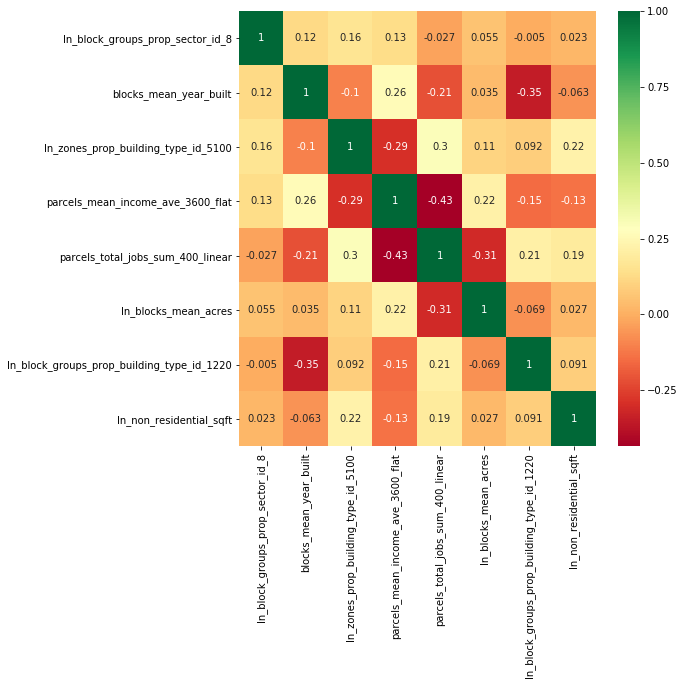

In [78]:
corr_plot(selected_variables)

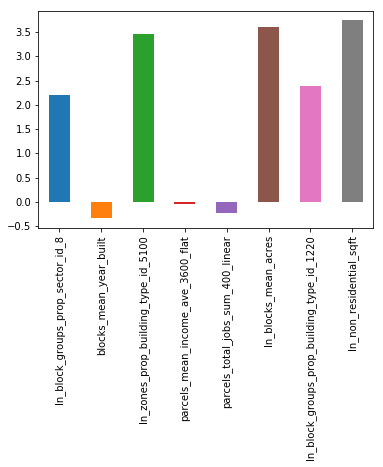

In [79]:
skew_plot(selected_variables)

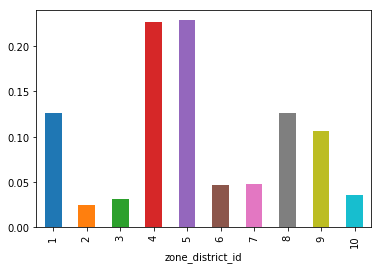

In [80]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

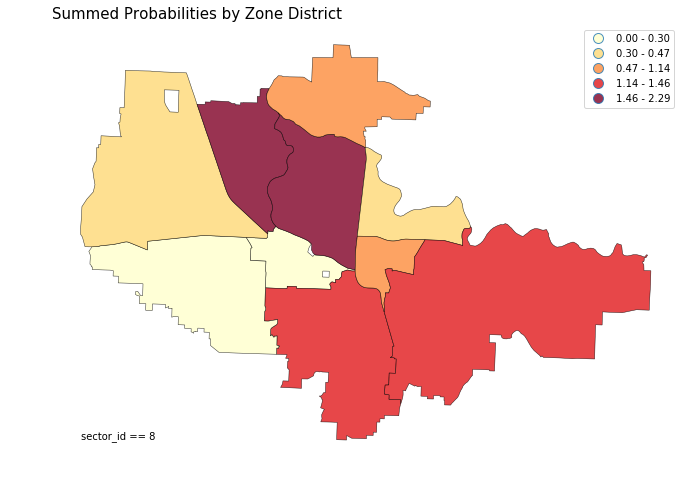

In [81]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

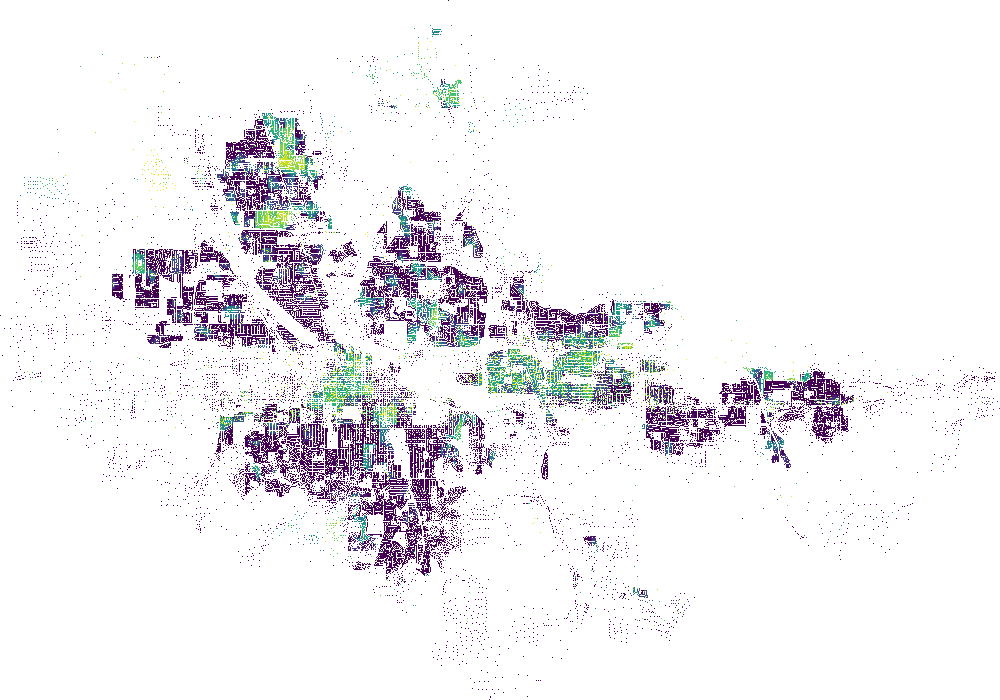

In [82]:
plot_probas(probas)

In [83]:
m.name = 'elcm8'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 8']
mm.register(m)

Saving 'elcm8.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm8'


## ELCM9: Manufacturing - High tech

In [84]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 9']

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [85]:
selected_variables = ['ln_parcels_density_jobs',
                      'ln_blocks_prop_repm_id_industrial',
                     'ln_zones_median_non_residential_sqft',
                     'parcels_total_jobs_sum_2000_linear',
                     'ln_blocks_median_acres',
                     'parcels_sum_persons_ave_400_linear']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_repm_id_industrial to buildings from blocks
Calculating proportion repm_id industrial for blocks
Disaggregating sum_persons_ave_400_linear to buildings from parcels
Calculating sum_persons of households for parcels
Disaggregating median_acres to buildings from blocks
Calculating median_acres of parcels for blocks
Disaggregating median_non_residential_sqft to buildings from zones
Calculating median_non_residential_sqft of buildings for zones
Disaggregating total_jobs_sum_2000_linear to buildings from parcels
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:            578
Model:         Multinomial Logit   Df Residuals:                572
Method:       Maximum Likelihood   Df Model:                      6
Date:                 2019-02-05   Pseudo R-squ.:             0.926
Time:                      16:33   Pseudo R-bar-squ.:         0.923
AIC:                     302.663   Log-Likelihood:         

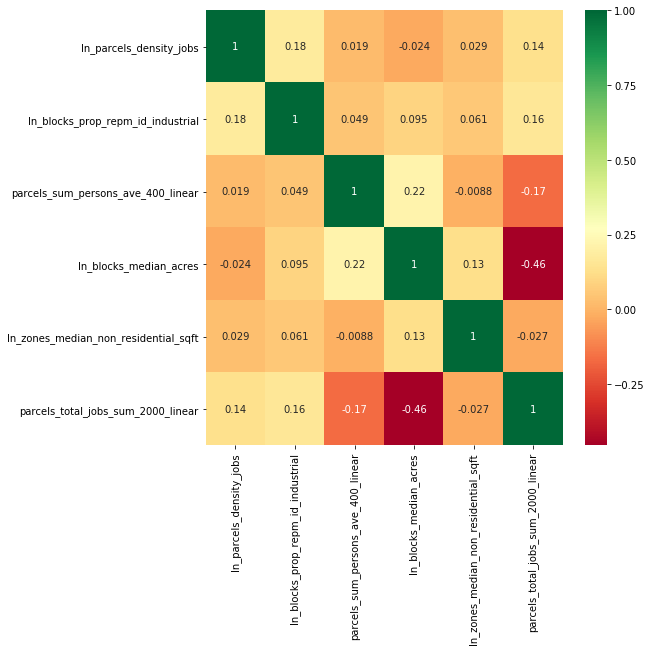

In [86]:
corr_plot(selected_variables)

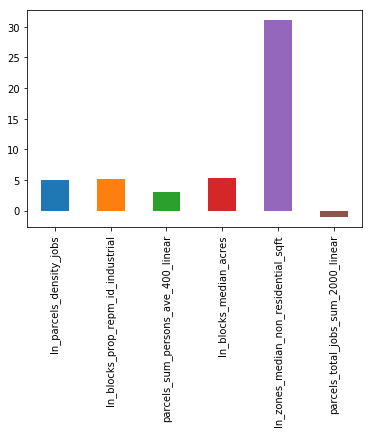

In [87]:
skew_plot(selected_variables)

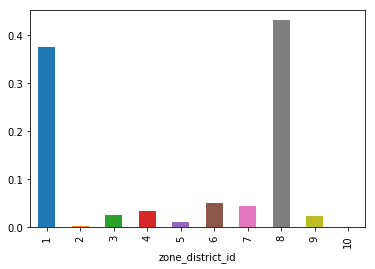

In [88]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

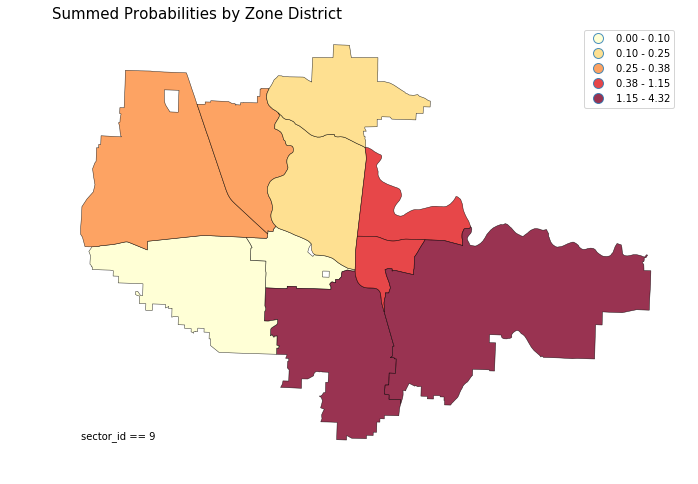

In [89]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

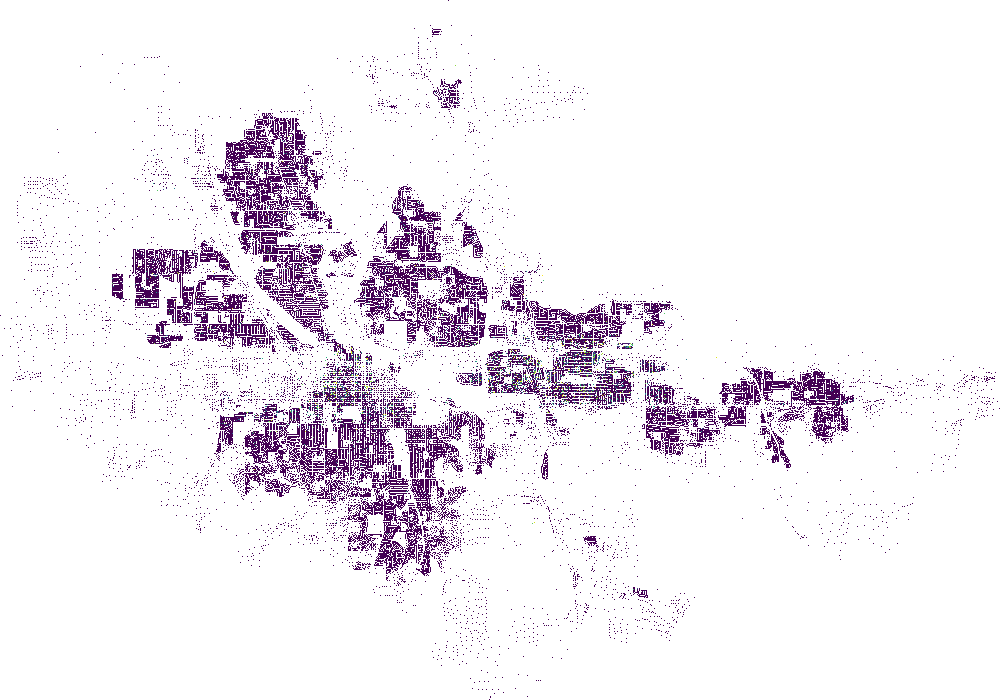

In [90]:
plot_probas(probas)

In [91]:
m.name = 'elcm9'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 9']
mm.register(m)

Saving 'elcm9.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm9'


## ELCM10 : Other Services (except Public Administration)

In [92]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 10']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [93]:
selected_variables = ['ln_parcels_mean_non_residential_sqft',
                     'ln_zones_total_jobs_10_md_offpeak_travel_time',
                     'parcels_mean_income_ave_1200_linear',
                     'zone_subdistricts_prop_building_type_id_1220',
                     'ln_zones_sum_persons_5_md_offpeak_travel_time',
                     'ln_blocks_total_jobs', ]

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating total_jobs_10_md_offpeak_travel_time to buildings from zones
Disaggregating total_jobs to buildings from blocks
Disaggregating prop_building_type_id_1220 to buildings from zone_subdistricts
Disaggregating zone_subdistrict_id to buildings from parcels
Calculating proportion building_type_id 1220.0 for zone_subdistricts
Calculating number of buildings for zone_subdistricts
Disaggregating mean_non_residential_sqft to buildings from parcels
Disaggregating mean_income_ave_1200_linear to buildings from parcels


        0.16654654]), array([[3017.60854558]]), {'grad': array([ 1.60206953e-05,  1.41490180e-06,  2.70259857e-07, -2.43953435e-08,
        6.16445405e-07,  4.56912323e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 38, 'warnflag': 2})


                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,994
Method:       Maximum Likelihood   Df Model:                      6
Date:                 2019-02-05   Pseudo R-squ.:             0.556
Time:                      16:33   Pseudo R-bar-squ.:         0.556
AIC:                   6,047.217   Log-Likelihood:       -3,017.609
BIC:                   6,080.823   LL-Null:              -6,802.395
                                                   coef   std err         z     P>|z|   Conf. Int.
--------------------------------------------------------------------------------------------------
ln_parcels_mean_non_residential_sqft             0.4613     0.008    58.848     0.000             
ln_zones_total_jobs_10_md_offpeak_travel_time   -0.0954     0.068    -1.396     0.163             
parcels_mean_income_ave_1200_linear              0.1186     

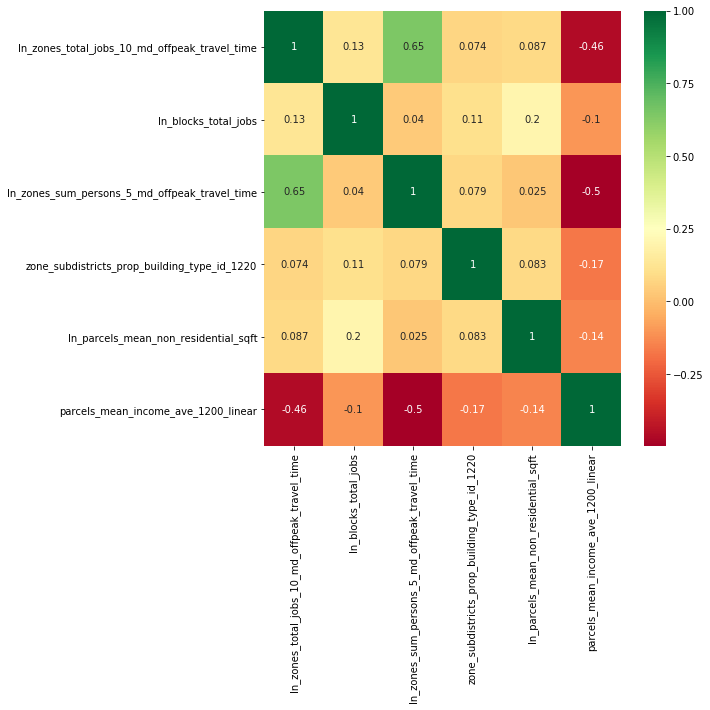

In [94]:
corr_plot(selected_variables)

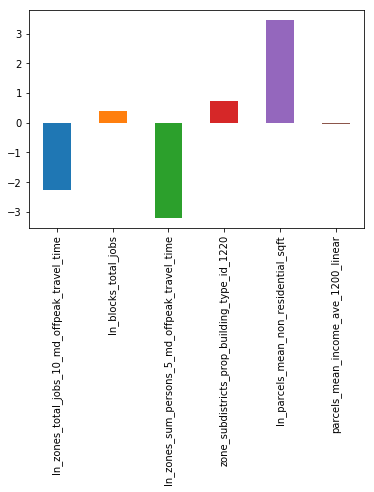

In [95]:
skew_plot(selected_variables)

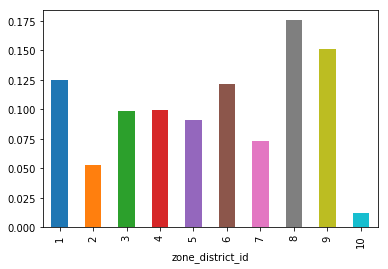

In [96]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

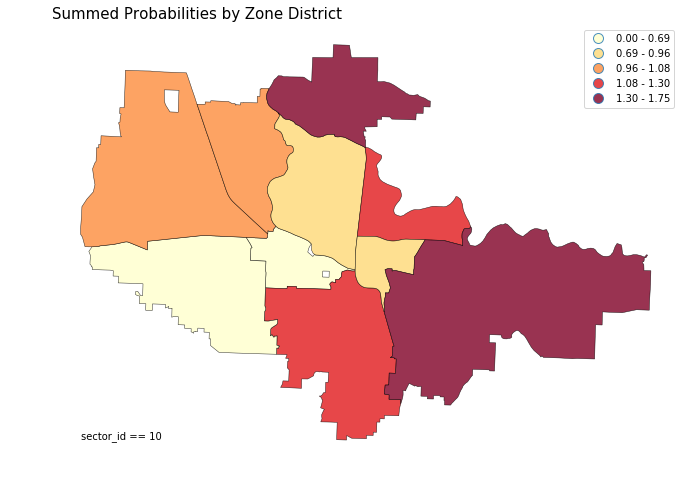

In [97]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

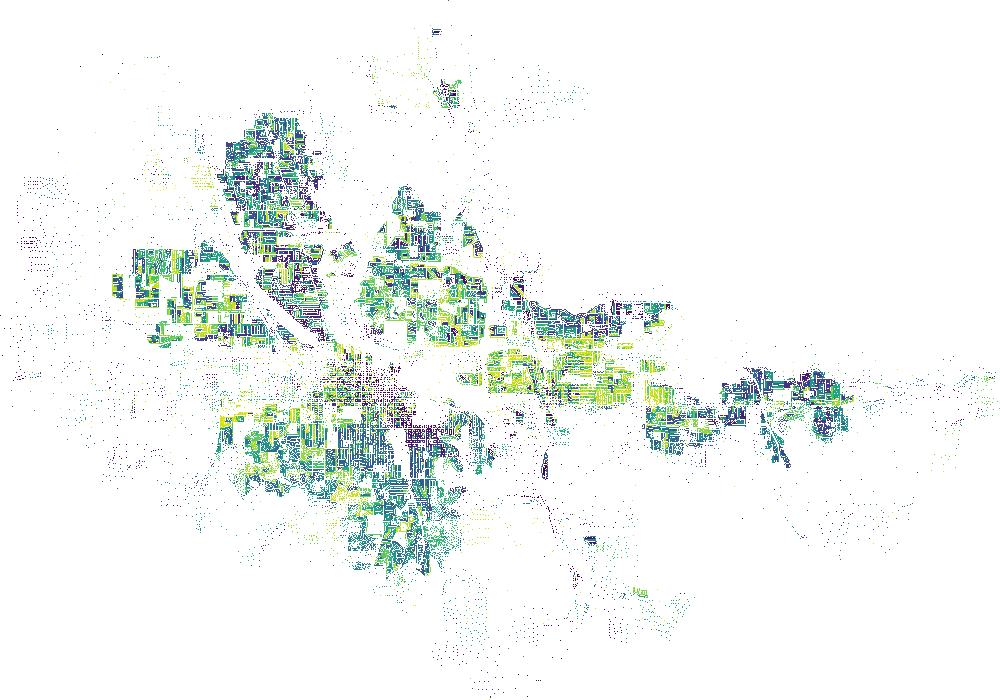

In [98]:
plot_probas(probas)

In [99]:
m.name = 'elcm10'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 10']
mm.register(m)

Saving 'elcm10.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm10'


## ELCM11: Professional and Business Services

In [100]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 11']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [101]:
selected_variables = ['ln_zones_sum_persons_10_am_peak_travel_time',
                     'block_groups_density_households',
                     'year_built',
                     'ln_parcels_prop_sector_id_11',
                     'ln_non_residential_sqft',
                     'ln_zones_prop_repm_id_retail',
                      'ln_blocks_prop_repm_id_office',
                      'ln_parcels_ratio_jobs_to_households'
                     ]

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_repm_id_retail to buildings from zones
Calculating proportion repm_id retail for zones
Disaggregating prop_sector_id_11 to buildings from parcels
Calculating proportion sector_id 11 for parcels
Disaggregating sum_persons_10_am_peak_travel_time to buildings from zones
Disaggregating density_households to buildings from block_groups
Calculating density of households for block_groups
Calculating number of households for block_groups
Disaggregating block_group_id to households from parcels
Disaggregating prop_repm_id_office to buildings from blocks
Calculating proportion repm_id office for blocks
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,992
Method:       Maximum Likelihood   Df Model:                      8
Date:                 2019-02-05   Pseudo R-squ.:             0.933
Time:                      16:33   Pseud

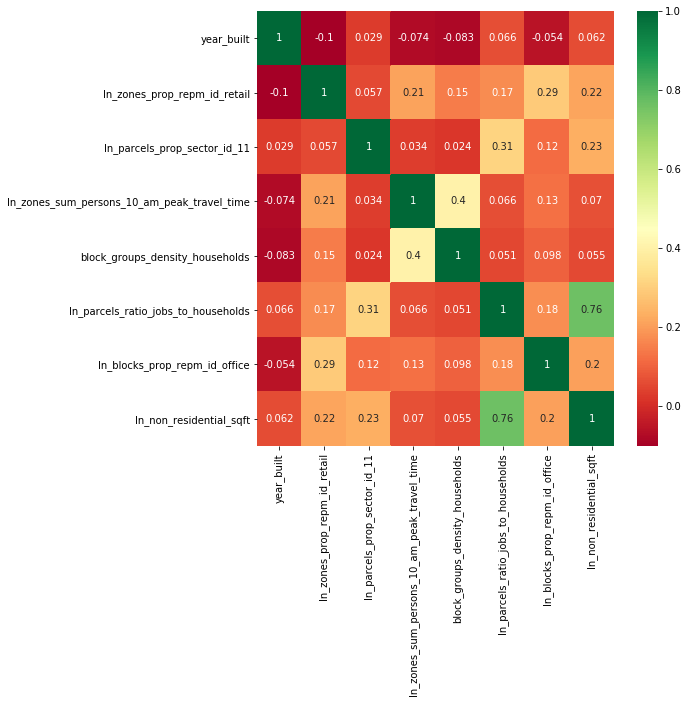

In [102]:
corr_plot(selected_variables)

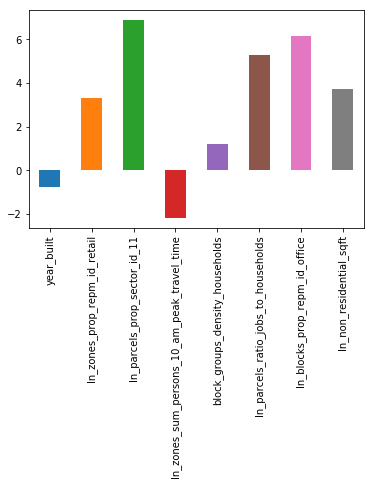

In [103]:
skew_plot(selected_variables)

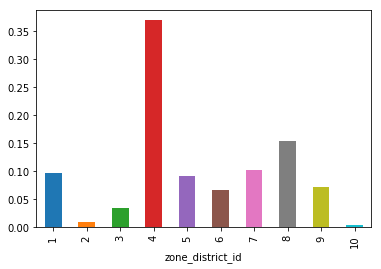

In [104]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

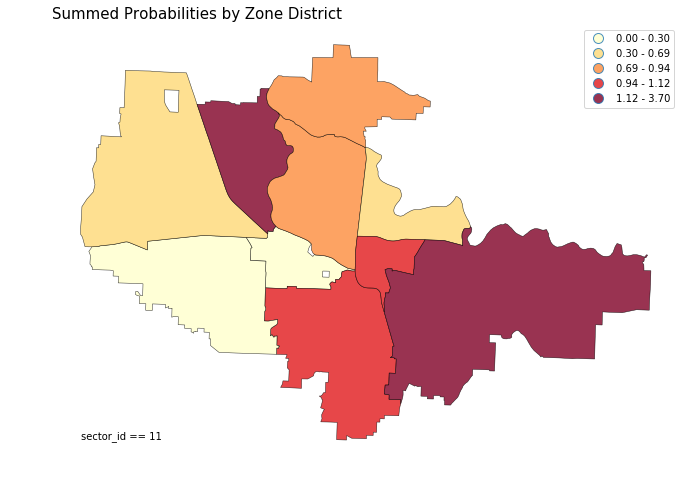

In [105]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

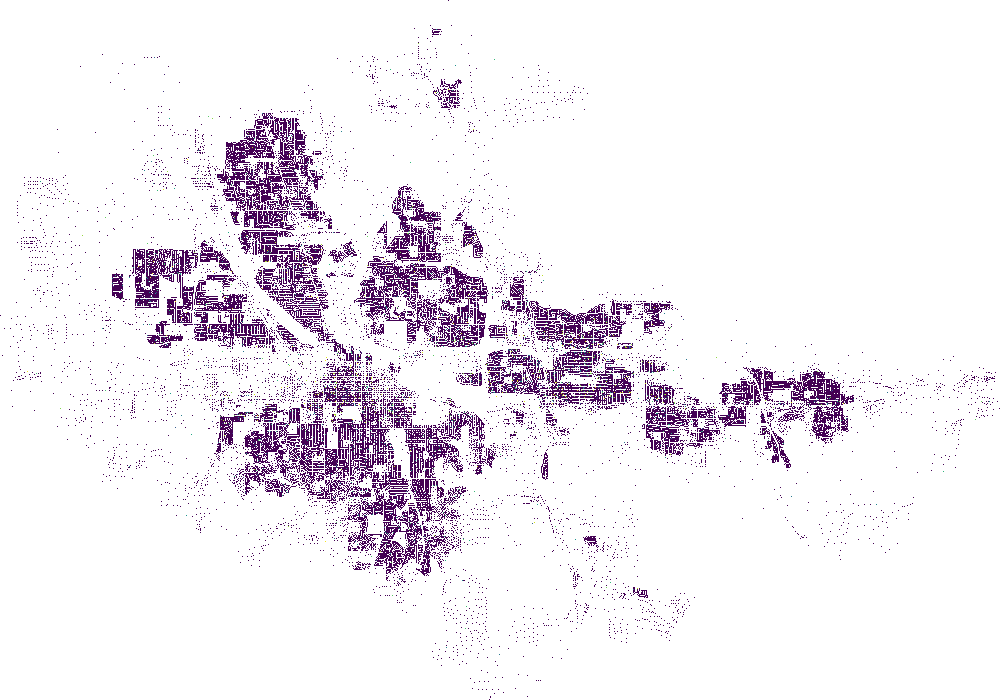

In [106]:
plot_probas(probas)

In [107]:
m.name = 'elcm11'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 11']
mm.register(m)

Saving 'elcm11.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm11'


## ELCM12: Retail and Consumer Services

In [108]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 12']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [109]:
selected_variables = ['zones_total_jobs_10_md_offpeak_travel_time',
                     'zones_prop_sector_id_12',
                      'zones_prop_sector_id_5',
                     'year_built',
                      'ln_parcels_ratio_jobs_to_households',
                     'ln_non_residential_sqft',
                     'ln_block_groups_prop_repm_id_multifamily',
                     'ln_blocks_total_jobs']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_sector_id_12 to buildings from zones
Calculating proportion sector_id 12 for zones
Disaggregating prop_repm_id_multifamily to buildings from block_groups
Calculating proportion repm_id multifamily for block_groups
Disaggregating prop_sector_id_5 to buildings from zones
Calculating proportion sector_id 5 for zones
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,992
Method:       Maximum Likelihood   Df Model:                      8
Date:                 2019-02-05   Pseudo R-squ.:             0.860
Time:                      16:33   Pseudo R-bar-squ.:         0.858
AIC:                   1,925.286   Log-Likelihood:         -954.643
BIC:                   1,970.093   LL-Null:              -6,802.395
                                                coef   std err         z     P>|z|   Conf. Int.
-------------------------

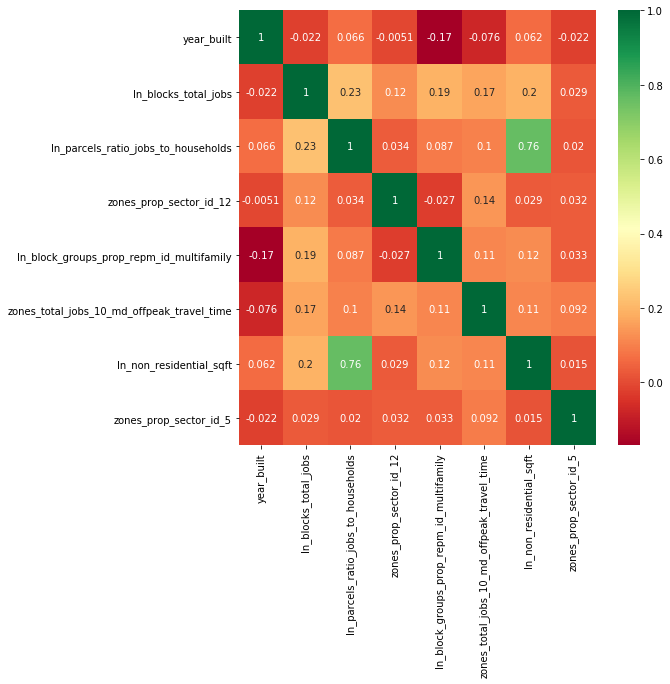

In [110]:
corr_plot(selected_variables)

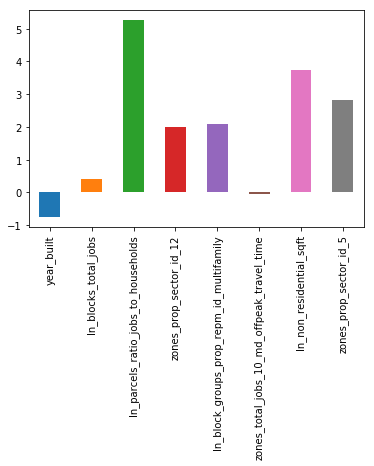

In [111]:
skew_plot(selected_variables)

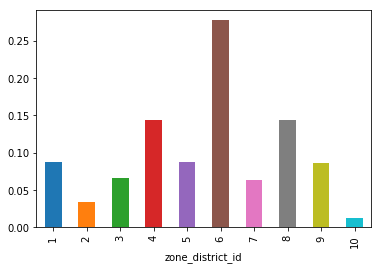

In [112]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

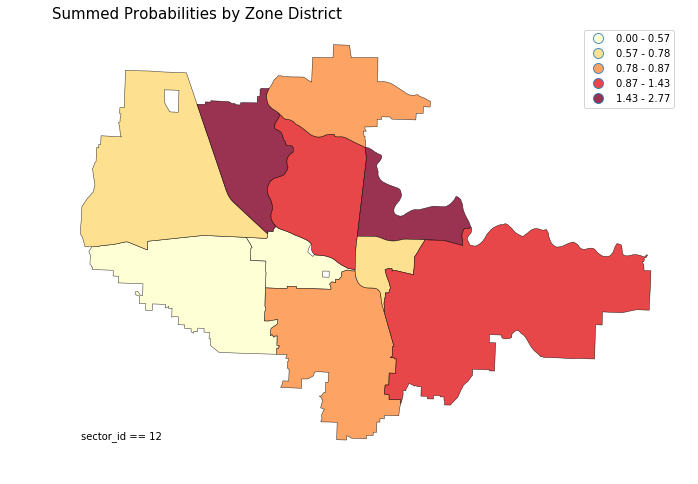

In [113]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

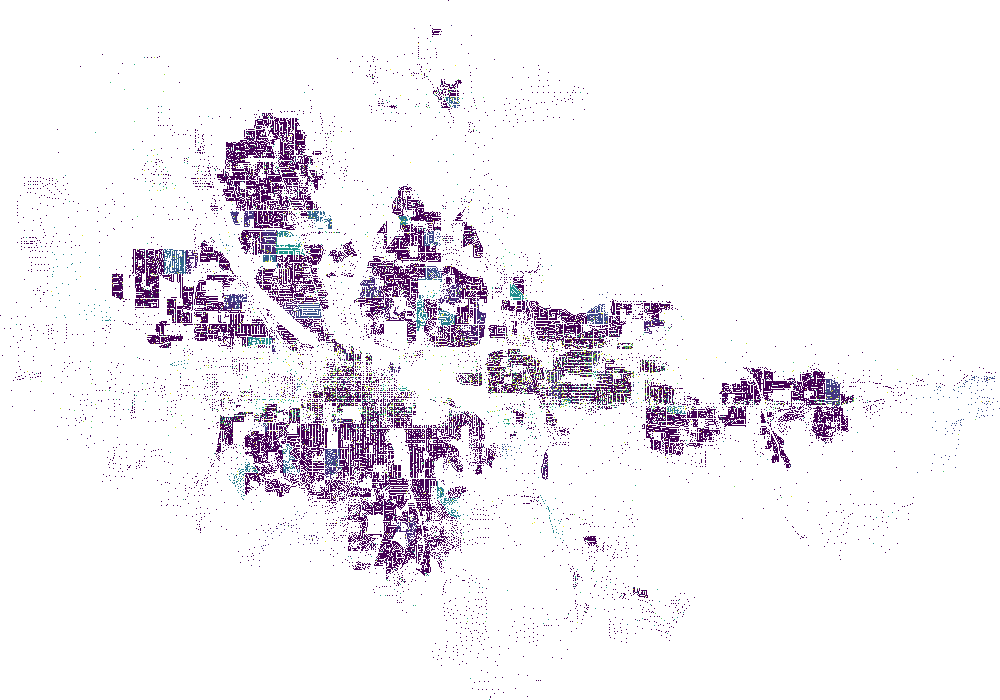

In [114]:
plot_probas(probas)

In [116]:
m.name = 'elcm12'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 12']
mm.register(m)

Saving 'elcm12.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm12'


## ELCM13 : Transportation, Warehousing and Utilities

In [117]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 13']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [118]:
selected_variables = ['ln_zones_prop_sector_id_13',
                     'ln_parcels_prop_building_type_id_5100',
                     'year_built',
                     'ln_non_residential_sqft',
                     'ln_blocks_median_acres',
                     'zone_subdistricts_prop_building_type_id_1220']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_sector_id_13 to buildings from zones
Calculating proportion sector_id 13 for zones
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,994
Method:       Maximum Likelihood   Df Model:                      6
Date:                 2019-02-05   Pseudo R-squ.:             0.791
Time:                      16:34   Pseudo R-bar-squ.:         0.790
AIC:                   2,853.230   Log-Likelihood:       -1,420.615
BIC:                   2,886.836   LL-Null:              -6,802.395
                                                  coef   std err         z     P>|z|   Conf. Int.
-------------------------------------------------------------------------------------------------
ln_zones_prop_sector_id_13                      9.4171     0.305    30.898     0.000             
ln_parcels_prop_building_type_id_5100           1.3761     

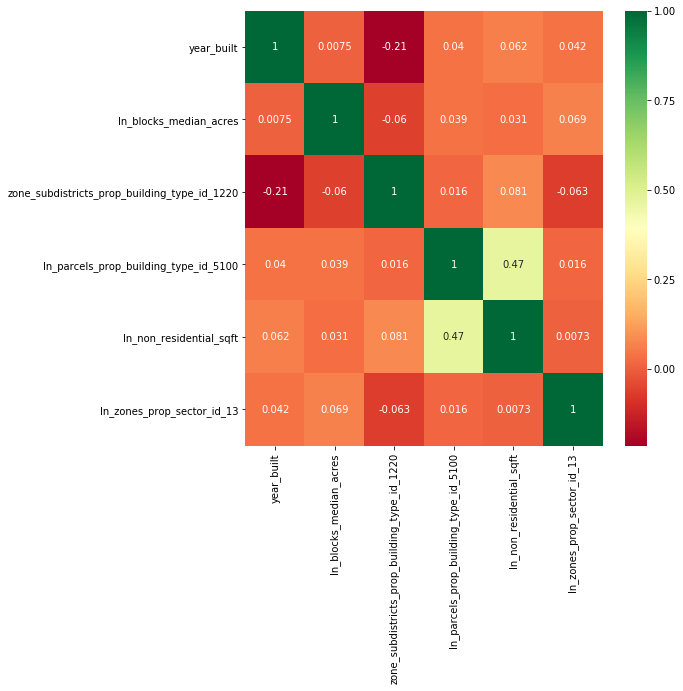

In [119]:
corr_plot(selected_variables)

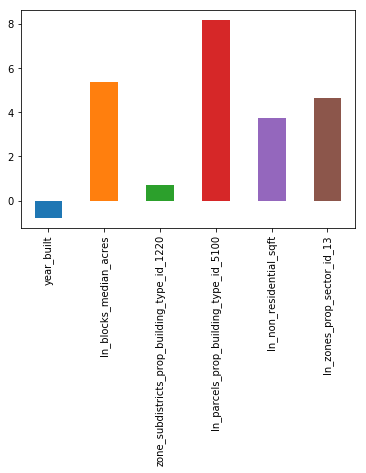

In [120]:
skew_plot(selected_variables)

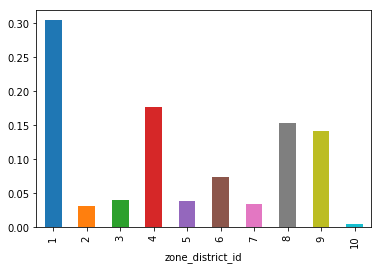

In [121]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

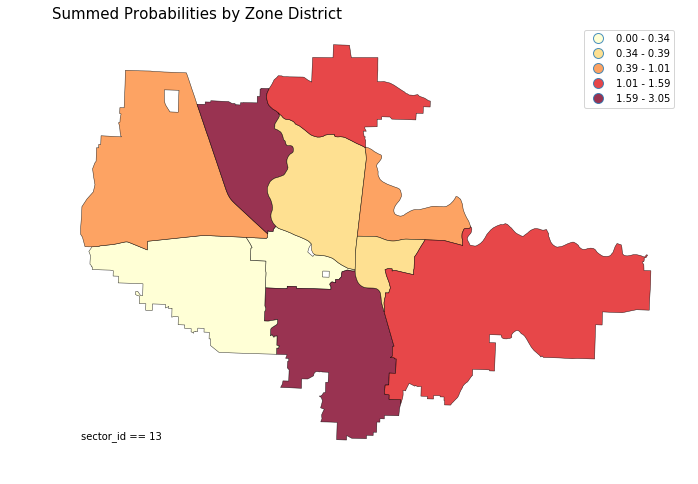

In [122]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

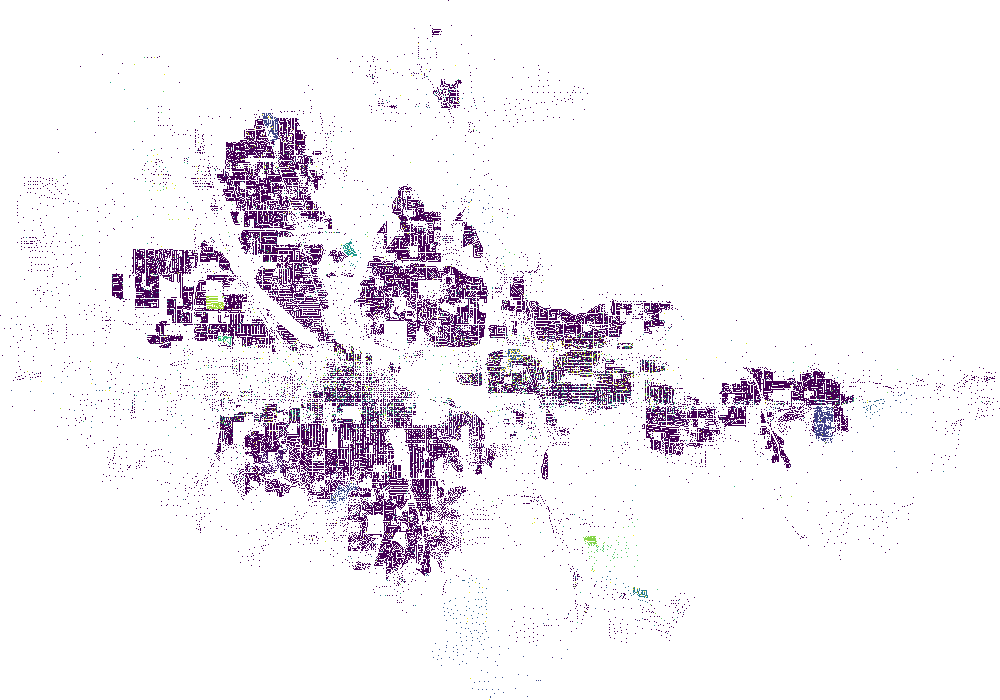

In [123]:
plot_probas(probas)

In [124]:
m.name = 'elcm13'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 13']
mm.register(m)

Saving 'elcm13.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm13'


## ELCM14 : Wholesale Trade

In [125]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 14']
m.chooser_sample_size = 2000

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [126]:
selected_variables = ['ln_blocks_median_acres',
                     'ln_blocks_prop_building_type_id_5100',
                     'ln_non_residential_sqft',
                     'zone_subdistricts_prop_building_type_id_1122',
                     'block_groups_density_buildings']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating prop_building_type_id_1122 to buildings from zone_subdistricts
Calculating proportion building_type_id 1122.0 for zone_subdistricts
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,000
Model:         Multinomial Logit   Df Residuals:              1,995
Method:       Maximum Likelihood   Df Model:                      5
Date:                 2019-02-05   Pseudo R-squ.:             0.747
Time:                      16:34   Pseudo R-bar-squ.:         0.746
AIC:                   3,452.815   Log-Likelihood:       -1,721.408
BIC:                   3,480.820   LL-Null:              -6,802.395
                                                  coef   std err         z     P>|z|   Conf. Int.
-------------------------------------------------------------------------------------------------
ln_blocks_median_acres                          0.0793     0.073     1.085     0.278             
ln_blocks_prop_

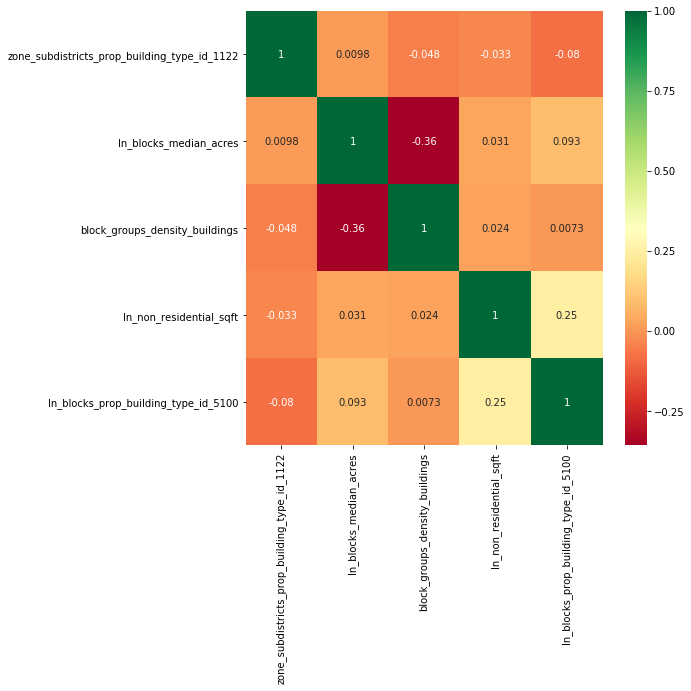

In [127]:
corr_plot(selected_variables)

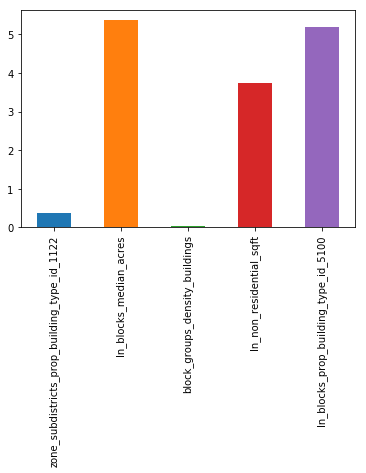

In [128]:
skew_plot(selected_variables)

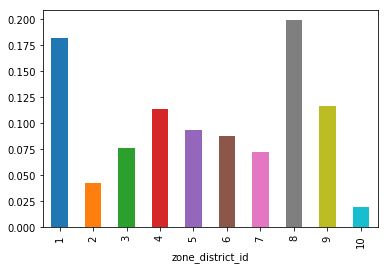

In [130]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

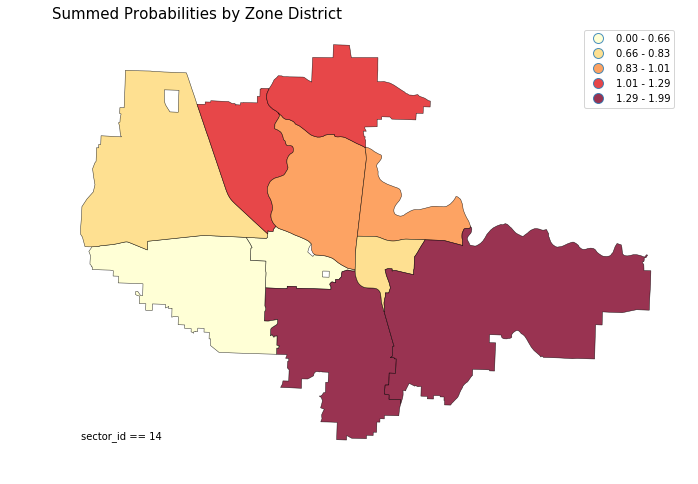

In [131]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

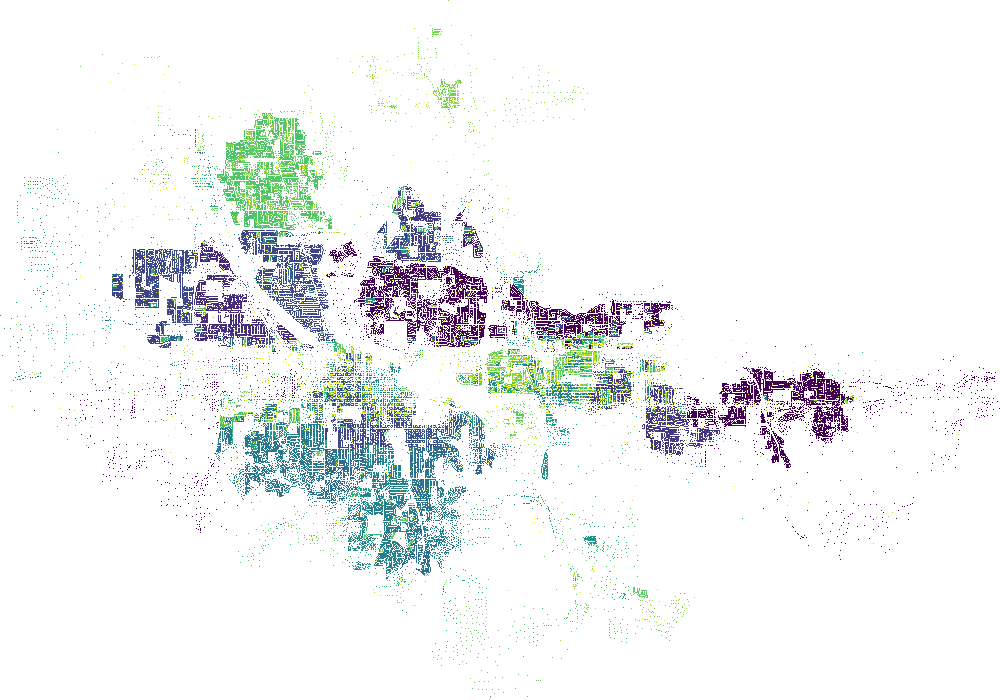

In [132]:
plot_probas(probas)

In [133]:
m.name = 'elcm14'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 14']
mm.register(m)

Saving 'elcm14.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm14'


## ELCM15 : Unknown

In [134]:
m = LargeMultinomialLogitStep()

# Define the agent whose behavior is being modeled
m.choosers = ['jobs']
m.chooser_filters = ['sector_id == 15']

# Define the geographic alternatives agent is selecting amongst
m.alternatives = ['buildings']
m.choice_column = 'building_id'
m.alt_sample_size = 30

In [135]:
selected_variables = ['ln_blocks_mean_acres',
                     'ln_blocks_mean_non_residential_sqft',
                     'locations_prop_building_type_id_1110',
                     'ln_zones_sum_persons_15_am_peak_travel_time']

m.model_expression = util.str_model_expression(selected_variables, add_constant=False)

m.fit()

Disaggregating mean_non_residential_sqft to buildings from blocks
Calculating mean_non_residential_sqft of buildings for blocks
Disaggregating prop_building_type_id_1110 to buildings from locations
Disaggregating location_id to buildings from parcels
Calculating proportion building_type_id 1110.0 for locations
Calculating number of buildings for locations
Disaggregating sum_persons_15_am_peak_travel_time to buildings from zones
                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:             18
Model:         Multinomial Logit   Df Residuals:                 14
Method:       Maximum Likelihood   Df Model:                      4
Date:                 2019-02-05   Pseudo R-squ.:             0.080
Time:                      16:34   Pseudo R-bar-squ.:         0.014
AIC:                     120.680   Log-Likelihood:          -56.340
BIC:                     124.242   LL-Null:                 -61.222
                        

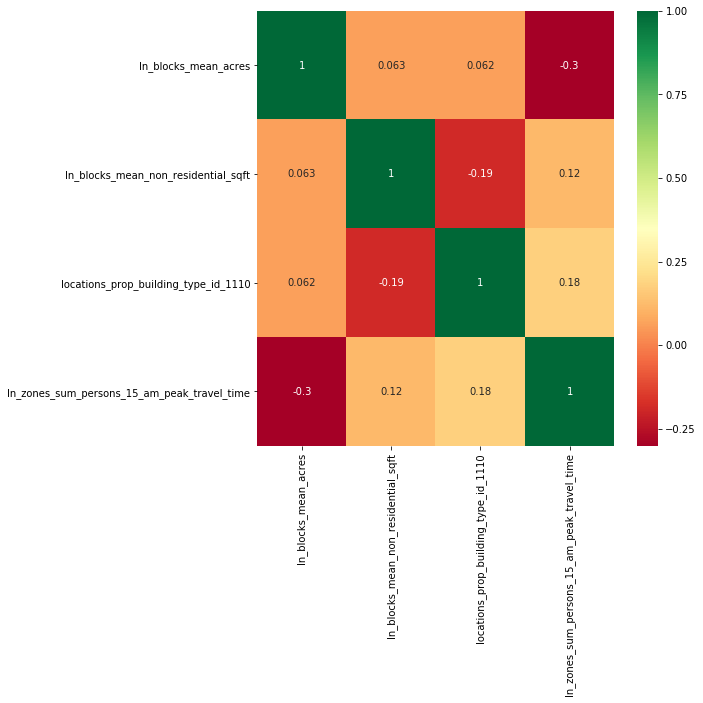

In [136]:
corr_plot(selected_variables)

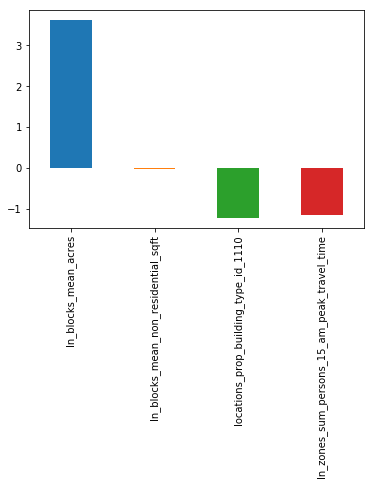

In [137]:
skew_plot(selected_variables)

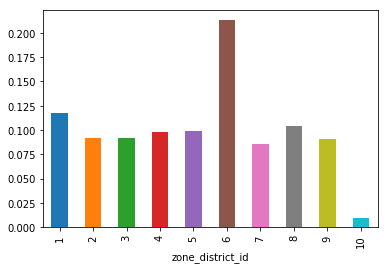

In [138]:
probas = create_probs_table(m, sample_choosers= 10)
summed_probas('zone_district_id', probas)

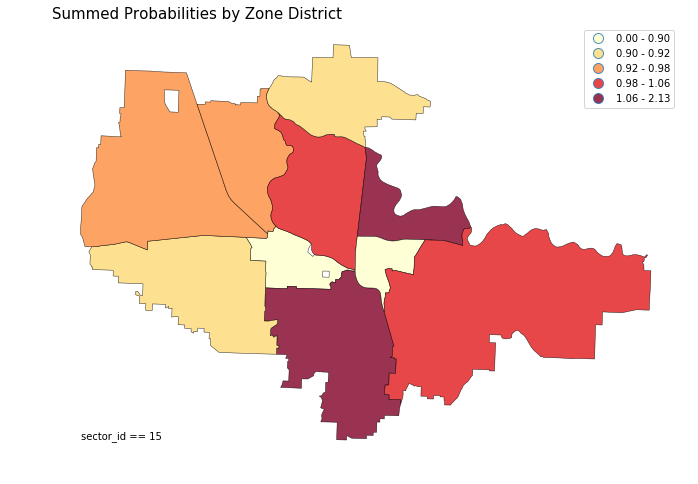

In [139]:
footnote = m.chooser_filters[0]
plot_probas_by_zonedistrict(probas, footnote)

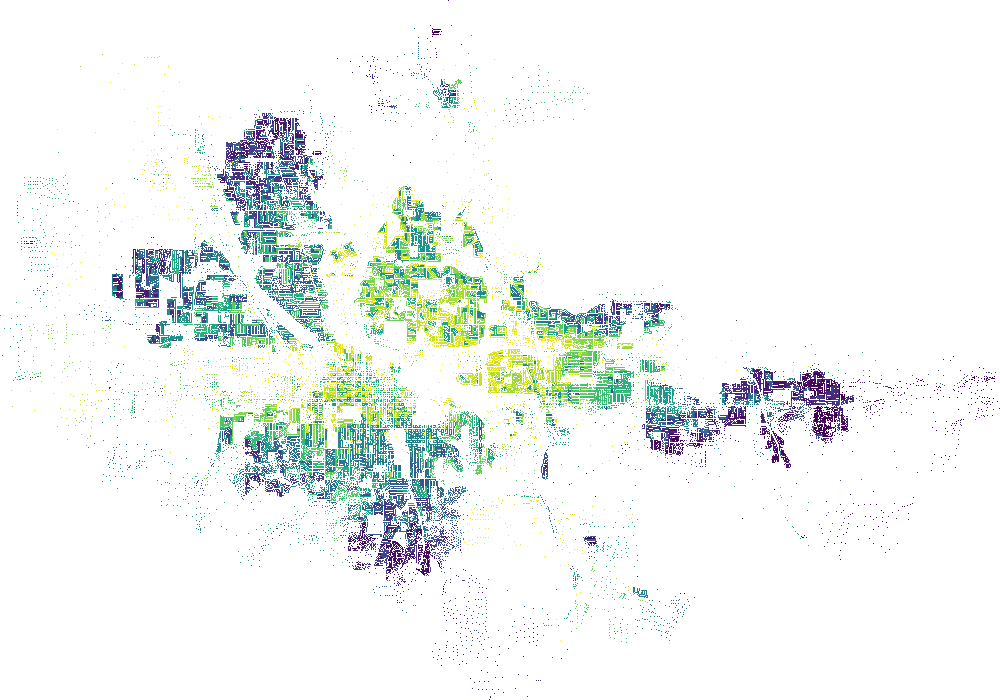

In [140]:
plot_probas(probas)

In [141]:
m.name = 'elcm15'
m.alt_capacity = 'job_spaces'
m.constrained_choices = True
m.out_column = 'building_id'
m.out_chooser_filters = ['building_id == -1', 'sector_id == 15']
mm.register(m)

Saving 'elcm15.yaml': C:\Users\Juan\Documents\GitHub\lcog\lcog\configs
Registering model step 'elcm15'
